In [1]:
import numpy as np
from numpy import inf
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap
import scipy
from scipy import io
import glob
import SAplotter
from SAplotter import *
from filedata import *
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from plotEO import plotEO

plotEO.py:6: SyntaxWarning: import * only allowed at module level
  def plotEO(data,minI,sumI,binwidth):


In [25]:
data = openFile('new_source_arrays/1130781304_source_array_ruby.sav')

In [ ]:
allIntensities(data)

In [ ]:
ext = extObj(data)

In [ ]:
def plotya(data):

    #this step changes the ra range from [0,360] to [-180,180]
    for i in range(len(data['source_array'])):
        if data['source_array'][i]['ra'] > 180: 
            data['source_array'][i]['ra'] -= 360                                                                                

    for i in range(len(data['source_array'])):
        if data['source_array'][i]['extend'] is not None:            
            for j in range(len(data['source_array'][i]['extend'])):
                if data['source_array'][i]['extend'][j]['ra'] > 180:
                    data['source_array'][i]['extend'][j]['ra'] -= 360
             
    #this step makes lists of ra, dec, and I values for plotting purposes
    all_ra = []
    all_dec = []
    all_I = []

    for i in range(len(data['source_array'])):
        all_ra.append(data['source_array'][i]['ra'])
        all_dec.append(data['source_array'][i]['dec'])
        all_I.append(data['source_array'][i]['flux']['i'])

    #this step plots all of the data in the file on ra/dec with a colorbar for Stokes I
    plt.figure()
    plt.scatter(all_ra,all_dec,c=all_I,s=10)
    #plt.xlim(-70,20)
    #plt.ylim(-70,-10)
    plt.title('All Sources')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    #plt.pcolor(X, Y, Z1, norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()), cmap='PuBu_r'
    plt.colorbar()
    plt.show()

In [ ]:
#this comes from another notebook
def plootEO(data,sumI,n_bins):
    from matplotlib.colors import LogNorm
    from numpy import inf
    
    separated = separator(data)
    
    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ]
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    
    
    for i in range(len(separated['extsources'])):
        for j in range(len(separated['extsources'][i])):
            if(sum(indexed_EO_sources_I[i][j]) > sumI):
                ra_zoom = [min(indexed_EO_sources_RA[i][j]),max(indexed_EO_sources_RA[i][j])]
                dec_zoom = [min(indexed_EO_sources_DEC[i][j]),max(indexed_EO_sources_DEC[i][j])]
                
                ra_total = np.array(indexed_EO_sources_RA[i][j])
                dec_total = np.array(indexed_EO_sources_DEC[i][j])
                flux_total = np.array(indexed_EO_sources_I[i][j])
                
                (pixels, ra_pixel_centers, dec_pixel_centers) = \
                pixelate(ra_zoom,dec_zoom,n_bins,ra_total,dec_total,flux_total)
                
                pixels[pixels == 0] = 1e-2
                logpixels = np.log10(pixels)                
                #cmap = matplotlib.cm.get_cmap('afmhot')
                cmap = matplotlib.cm.get_cmap('hot')
                
                #trying out some gaussian convolution
                kernel = Gaussian2DKernel(stddev=1)
                #scipy_conv = scipy_convolve(pixels, kernel, mode='same', method='direct')
                #astropy_conv = convolve(pixels, kernel)
                smoothed_data = convolve(pixels, kernel)
                #dont mind me
                
                plt.figure(figsize=(9,8))
                plt.imshow(np.transpose(smoothed_data),\
                    origin = "lower", \
                    interpolation = "none",\
                    #vmin=0.001,\
                    #vmax=2,\
                    norm = LogNorm(vmin=.01,vmax=max(flux_total)),\
                    cmap = cmap,\
                    extent = [ra_pixel_centers[0], ra_pixel_centers[len(ra_pixel_centers)-1], \
                    dec_pixel_centers[0], dec_pixel_centers[len(dec_pixel_centers)-1]])
                
                #tryna put in a circle of radius 2 arcmin.
                #circ = plt.Circle((50.4,-37.0), radius=0.3333, color='g')
                #

                plt.title('ObsID: {} at Frequency {}'.format(separated['extsources'][i][j]['ID'], separated['extsources'][i][j]['FREQ']), fontsize = 20)
                plt.xlabel('RA', fontsize = 14)
                plt.ylabel('DEC', fontsize = 14)
                plt.tick_params(size = 8, labelsize = 12)
                plt.minorticks_on()
                plt.tick_params('both', length=12, width=1.8, which='major')
                plt.tick_params('both',length=5, width=1.4, which='minor')
                
                plt.annotate("ID: {}\nComponents: {}\nTotal Flux: {}\nMean RA: {}\nMean Dec: {}".format \
                    (separated['extsources'][i][j]['ID'], len(indexed_EO_sources_I[i][j]), np.sum(indexed_EO_sources_I[i][j]), \
                    np.mean(indexed_EO_sources_RA[i][j]), np.mean(indexed_EO_sources_DEC[i][j])),\
                    xy=(1.5, .5), xytext=(0, 0),\
                    xycoords=('axes fraction', 'figure fraction'),\
                    textcoords='offset points',\
                    size=14, ha='center', va='bottom')
                
                plt.colorbar(label='Janskies')
                # plt.savefig('pixelatedEO'+'{}'.format(separated['extsources'][i][j]['ID'])+'.png')
    return plt.show()


In [ ]:
data1 = collector('new_source_arrays/1130781304_source_array_ruby.sav')
data2 = collector('new_source_arrays/1130784064_source_array.sav')
data3 = collector('new_source_arrays/1130788624_source_array.sav')

In [ ]:
dataset1 = collector('southern_sidelobe_decons/*.sav')

In [ ]:
allIntensities(data2['data'][0])

In [ ]:
allIntensities(data3['data'][0])

In [ ]:
plotya(data1['data'][0])

In [ ]:
plotya(data2['data'][0])

In [ ]:
plotya(data3['data'][0])

In [ ]:
plootEO(data1,30,150)

In [ ]:
plootEO(data2,10,150)

In [ ]:
plootEO(data3,10,150)

In [ ]:
for i in range(len(dataset1['data'])):
    print plotya(dataset1['data'][i])

In [ ]:
plootEO(dataset1,20,150)

In [ ]:
goon = separator(data)

In [ ]:
plotEO(data1,4,100,0.01)

In [ ]:
plotEO(data2,4,100,0.01)

In [2]:
dataa = collector('new_source_arrays/*.sav')

In [52]:
dataa1 = collector('new_source_arrays/1130784064_source_array.sav')

In [53]:
dataa2 = collector('new_source_arrays/1130788624_source_array.sav')

In [50]:
plotEO(dataa,3,20,0.0055)

KeyError: 1

In [11]:
thedata = collector('southern_sidelobe_decons/*.sav')

52
29
95
34
39
57
58
23
64
78
99
65
91
11
39
58
60
36
75
36
58
82


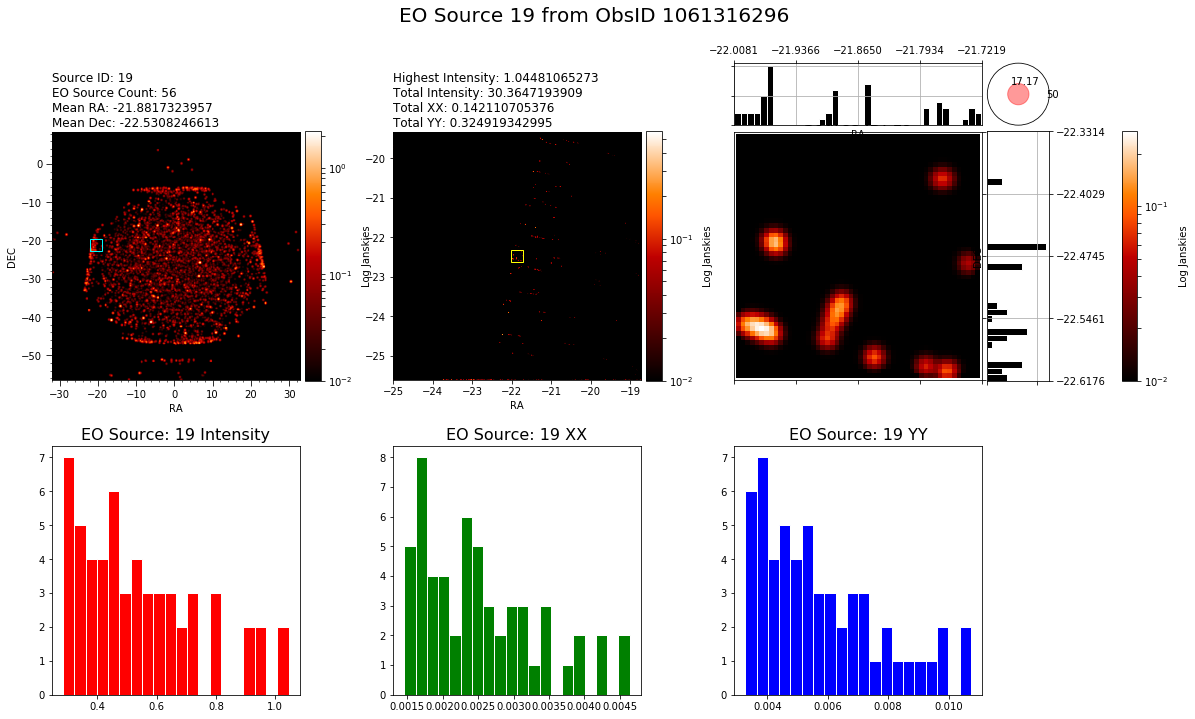

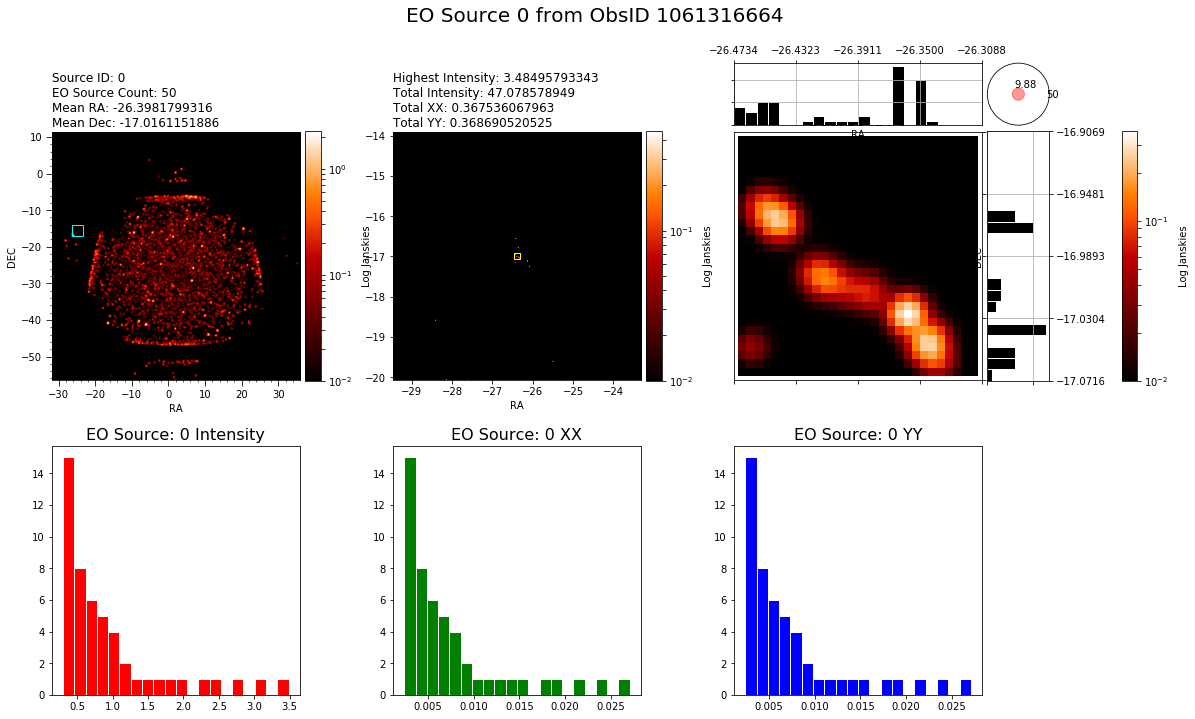

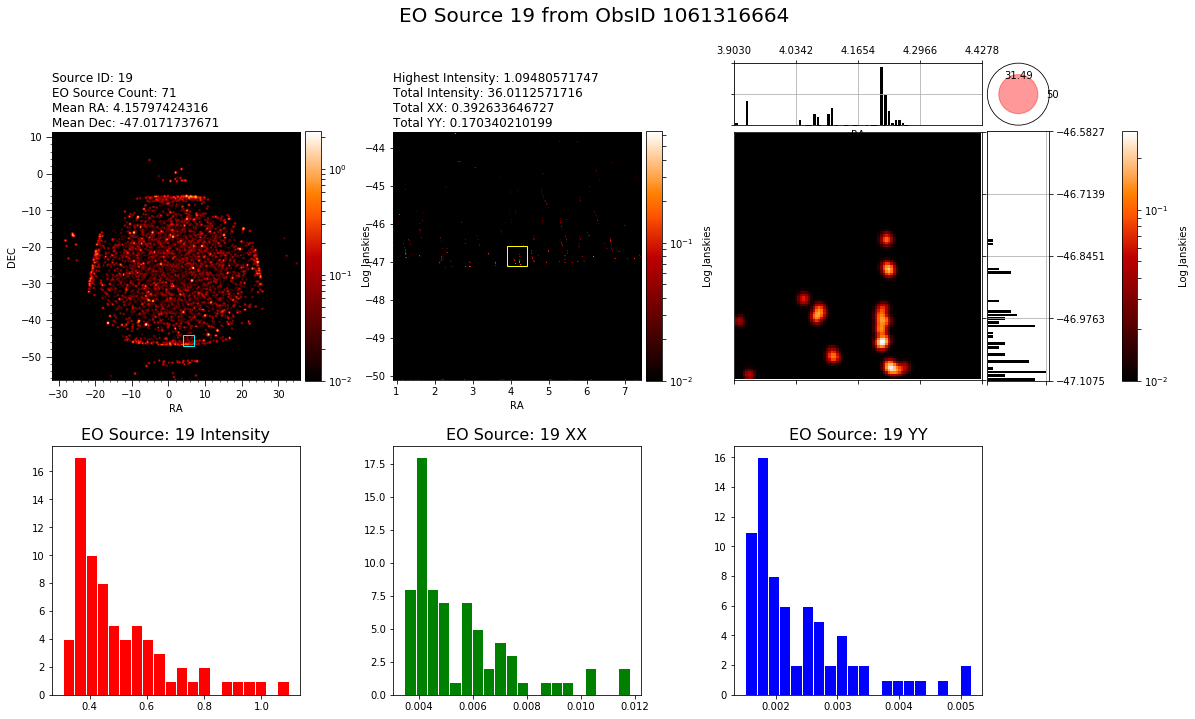

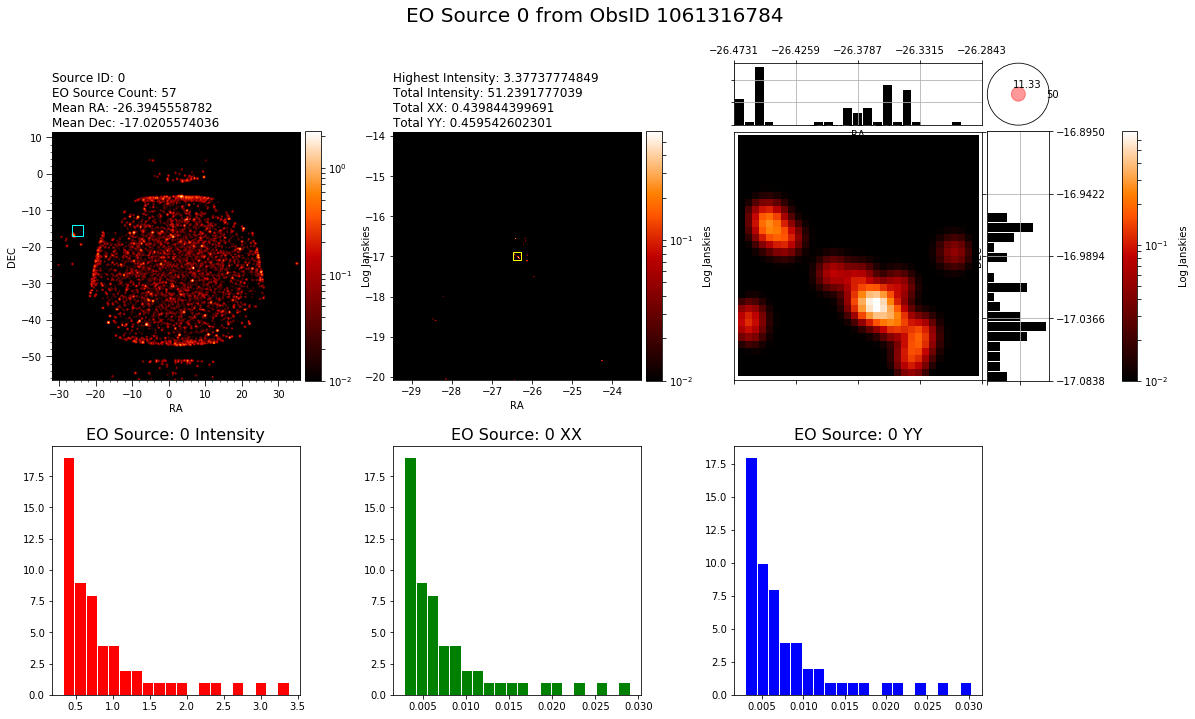

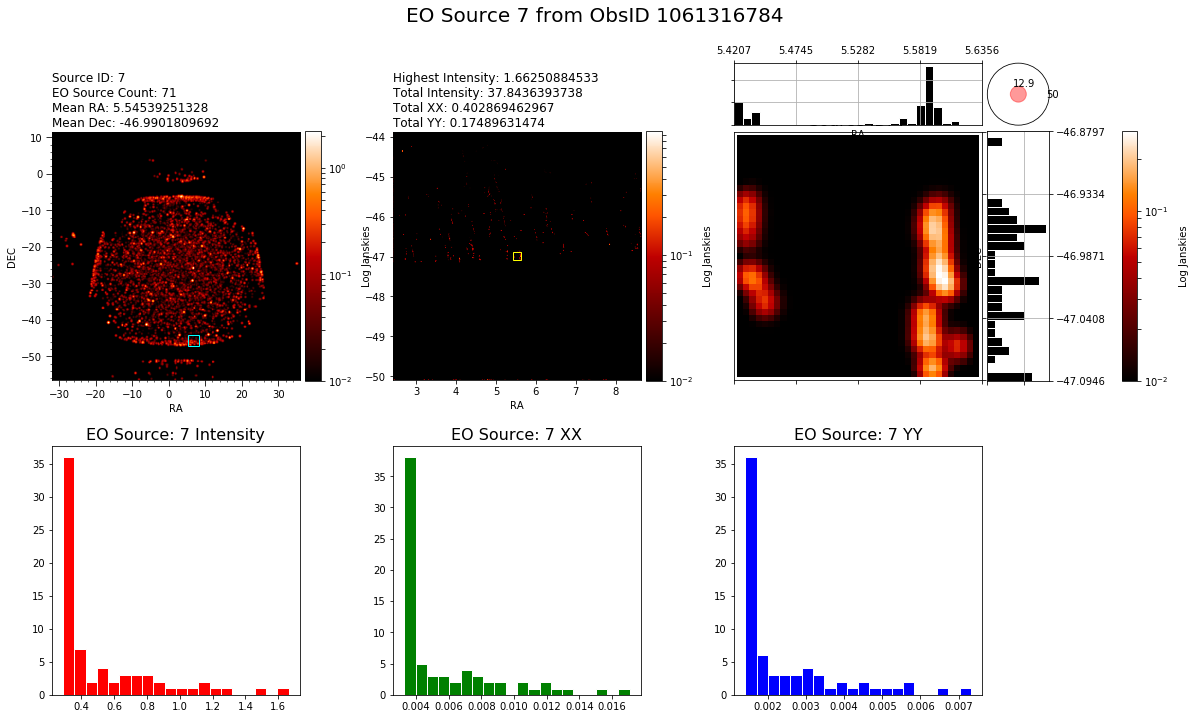

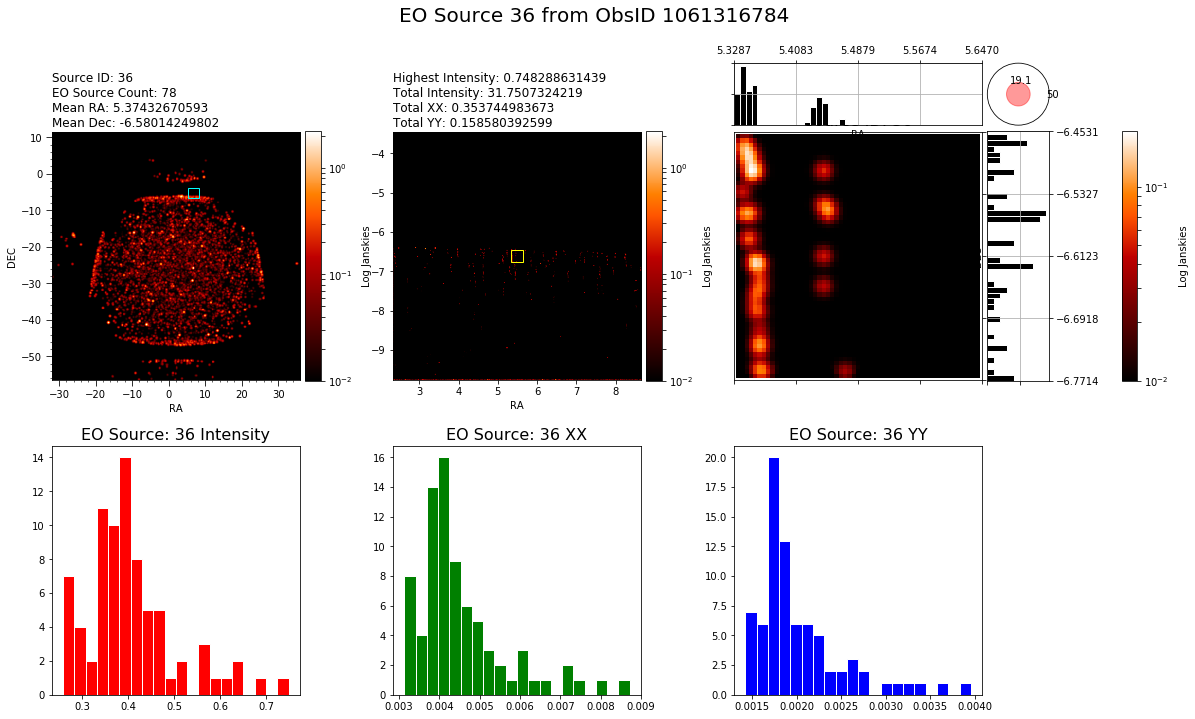

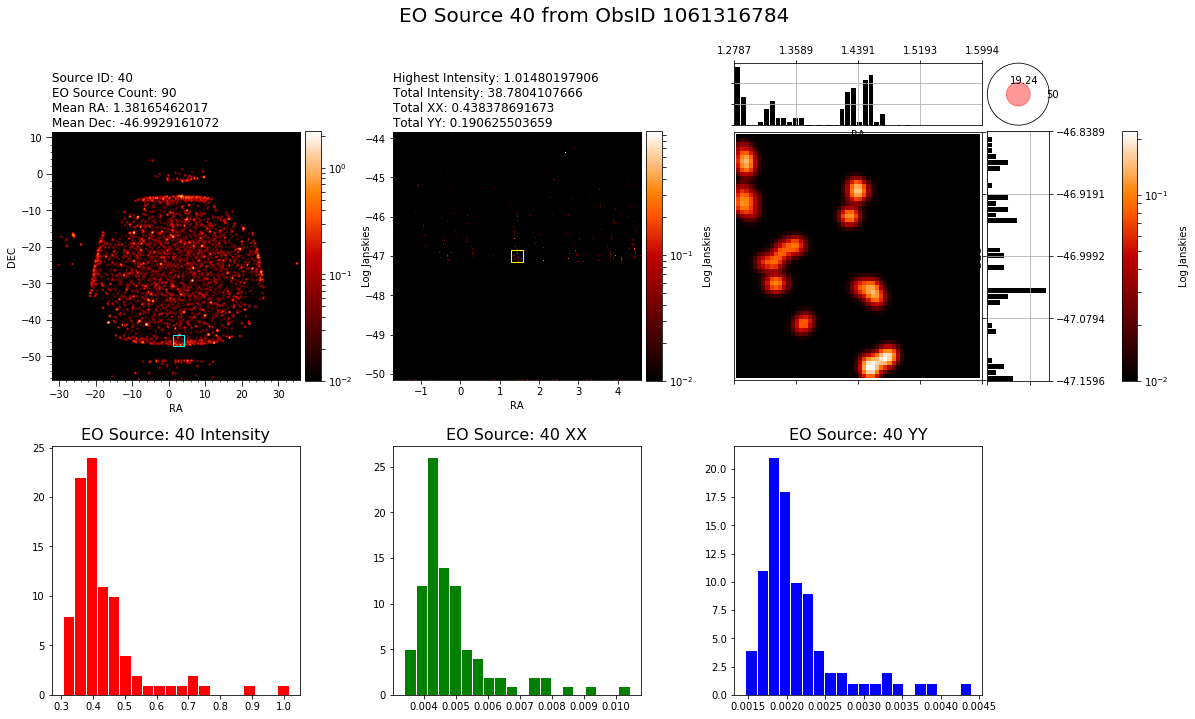

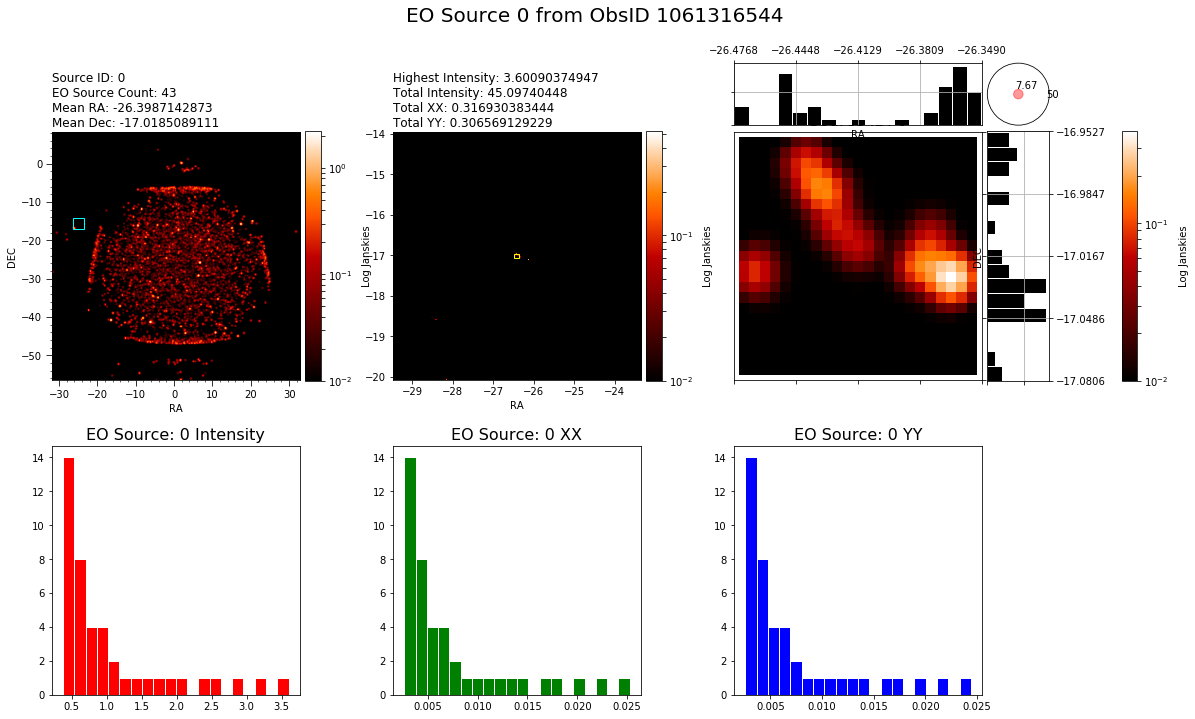

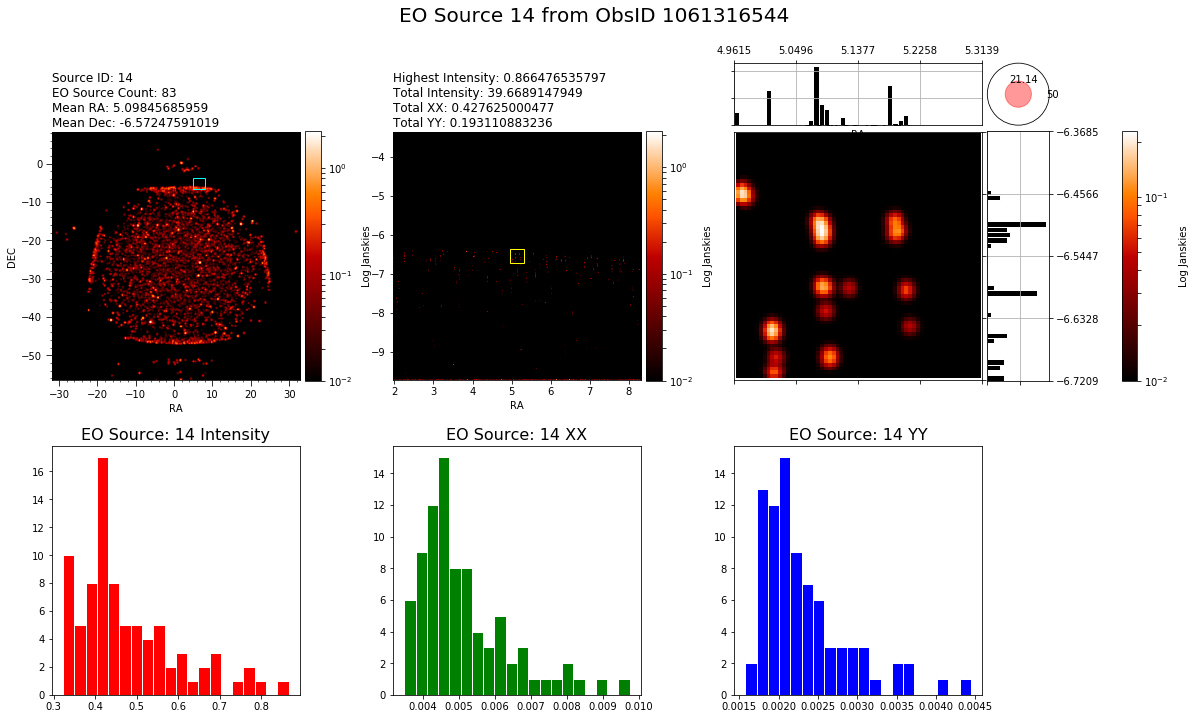

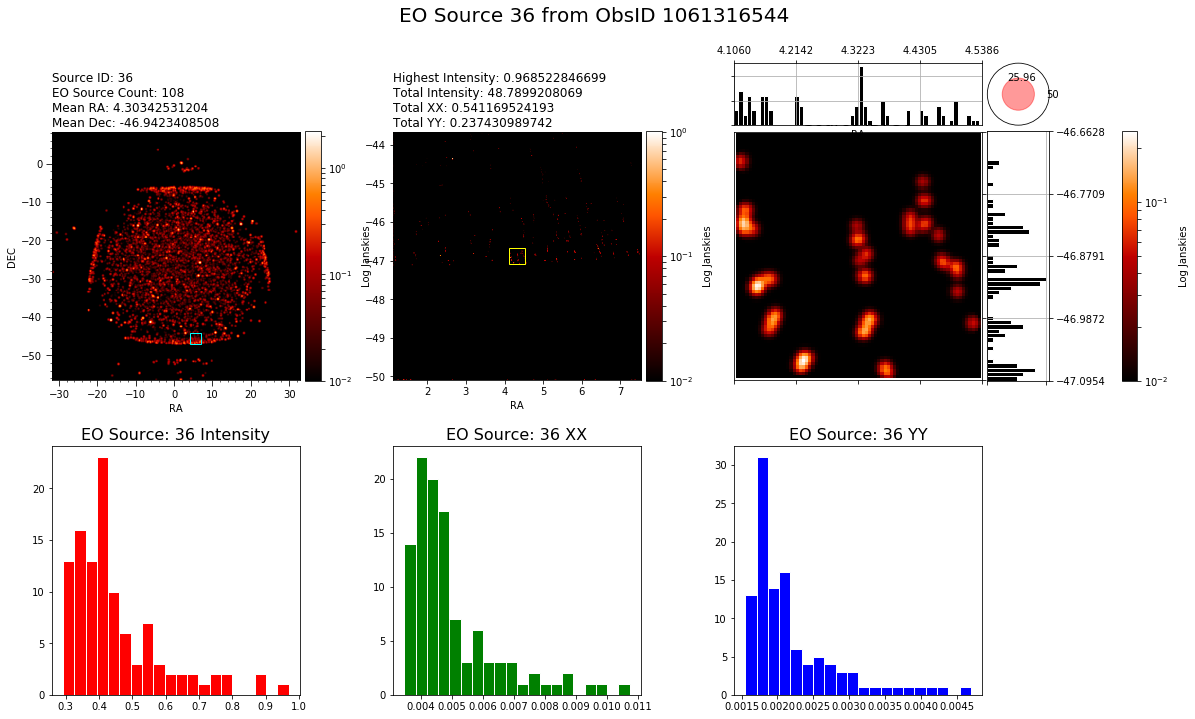

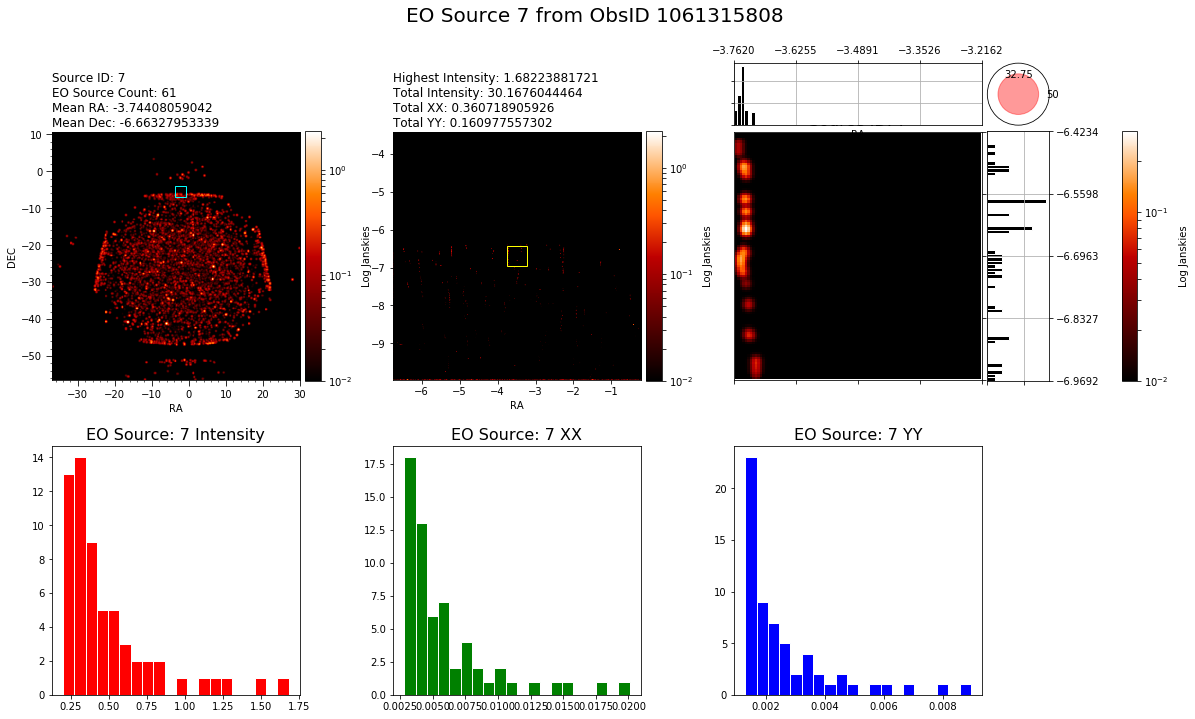

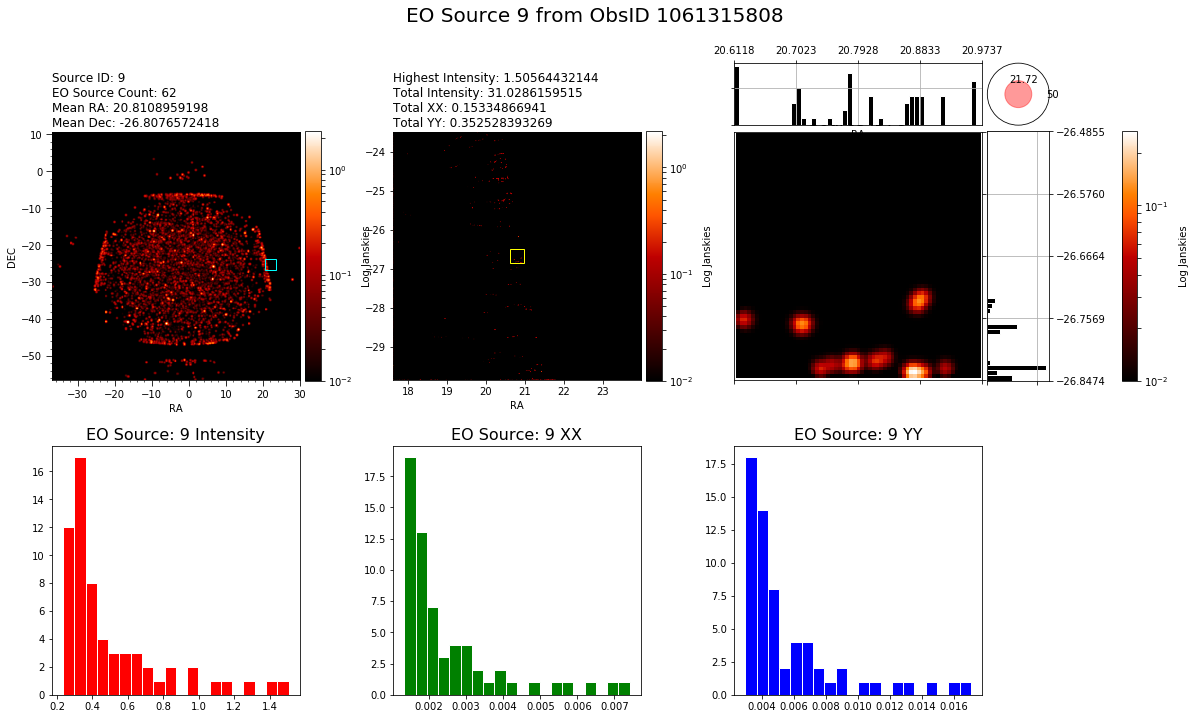

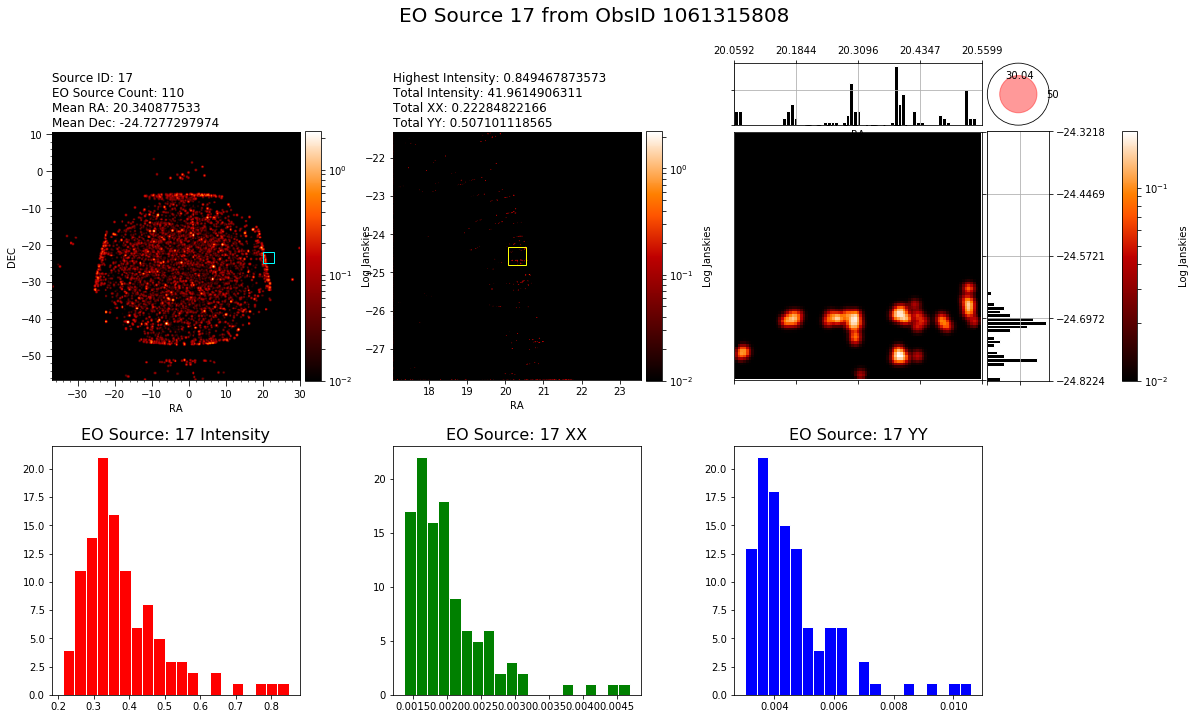

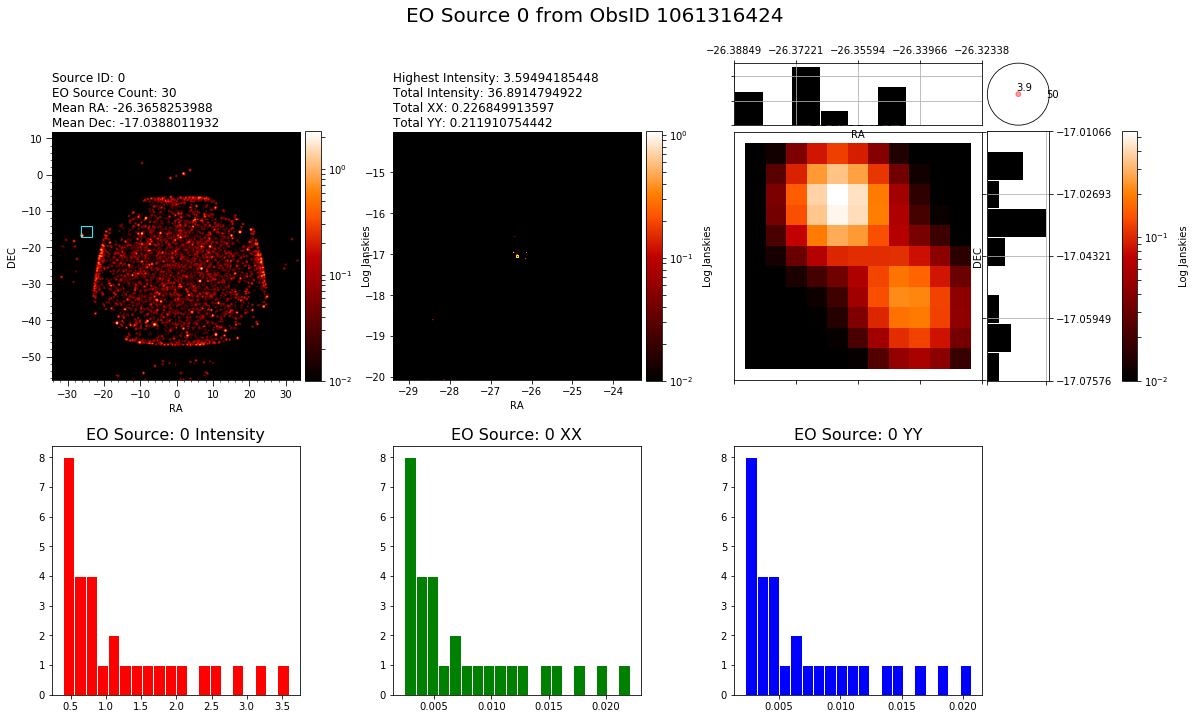

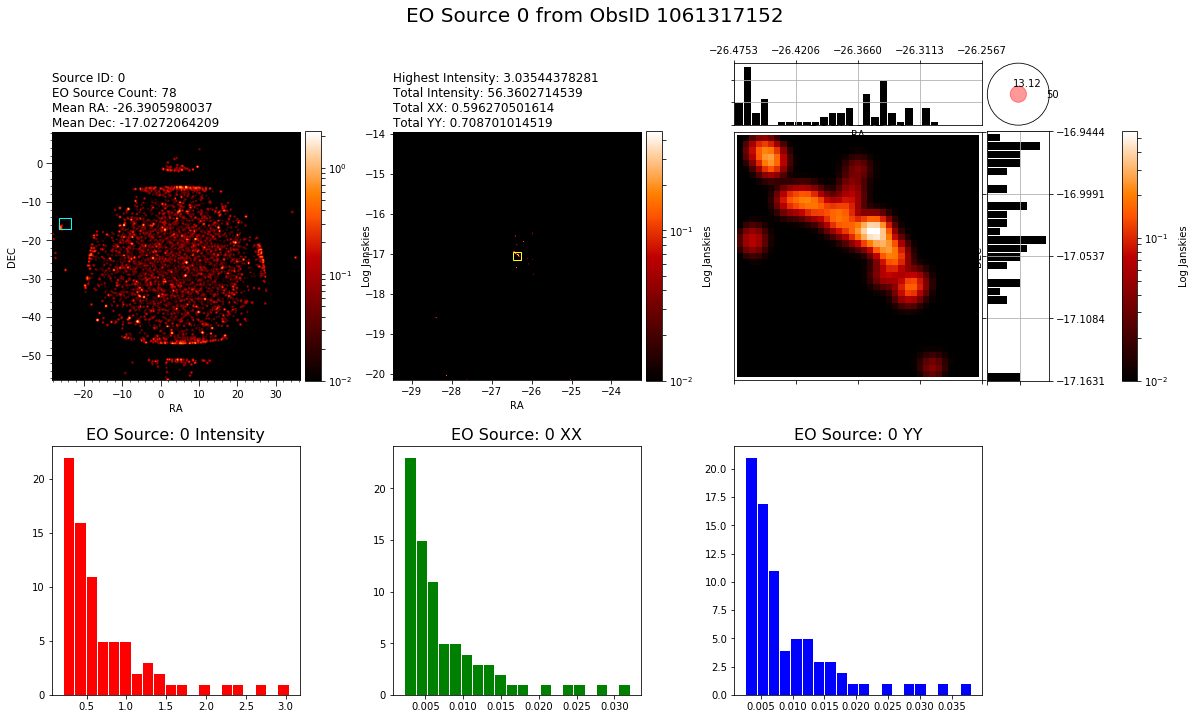

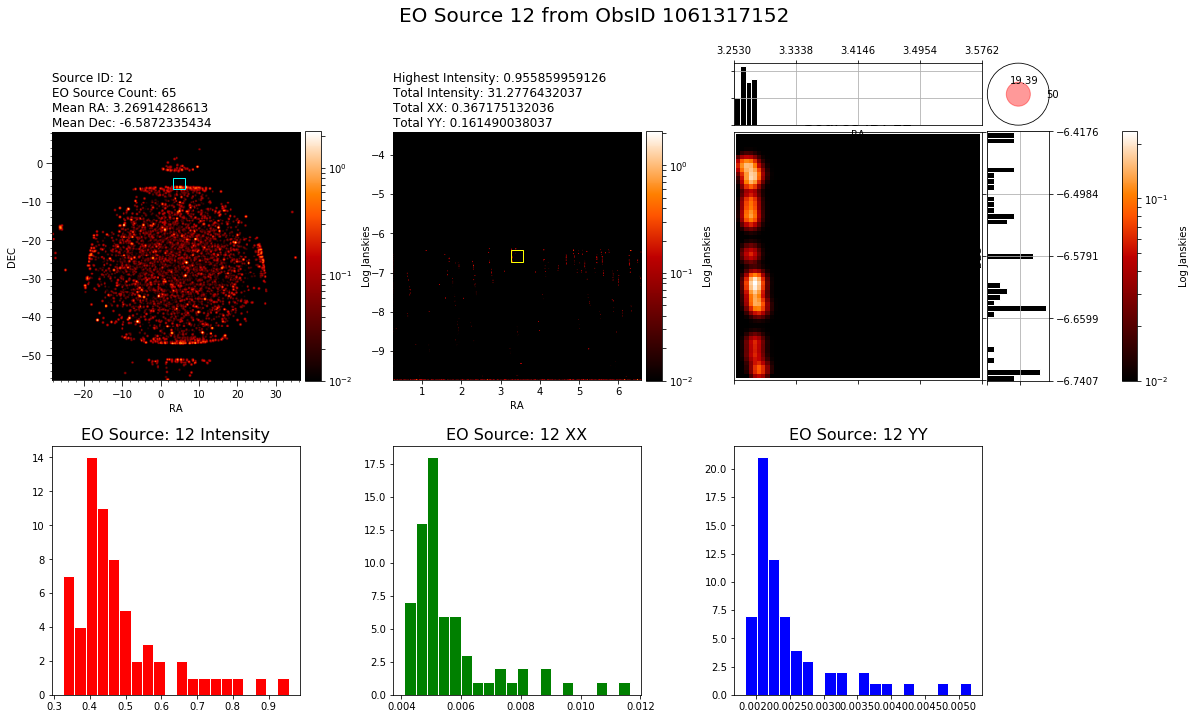

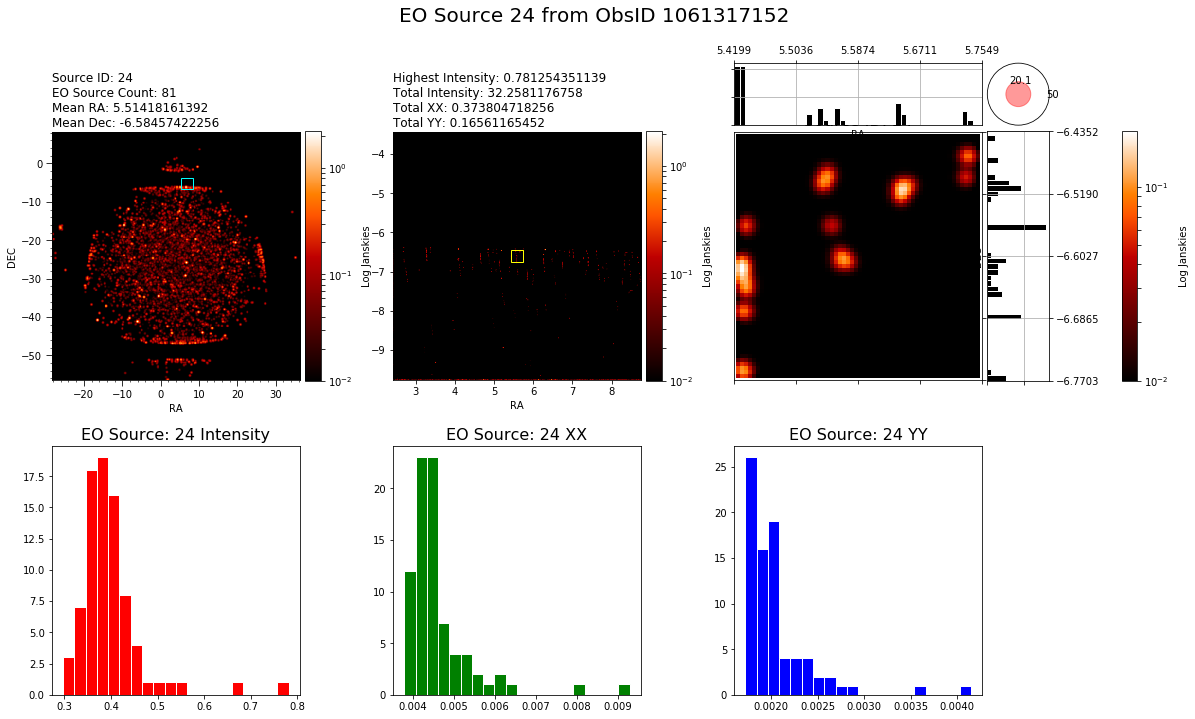

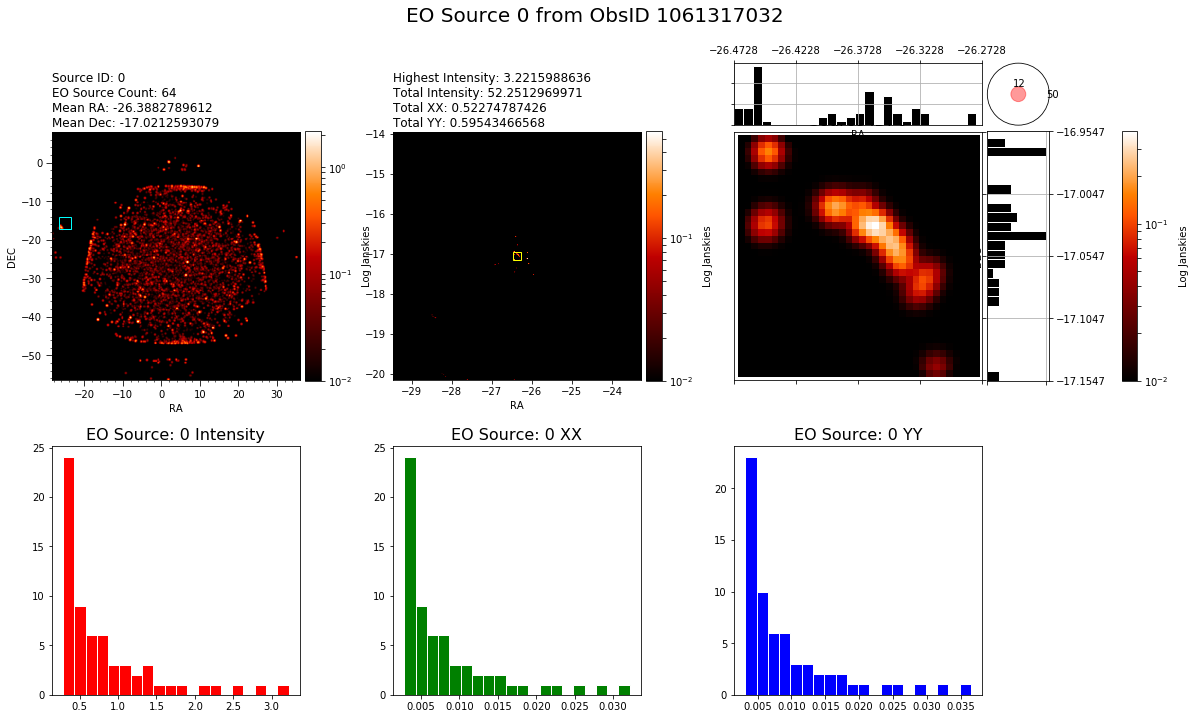

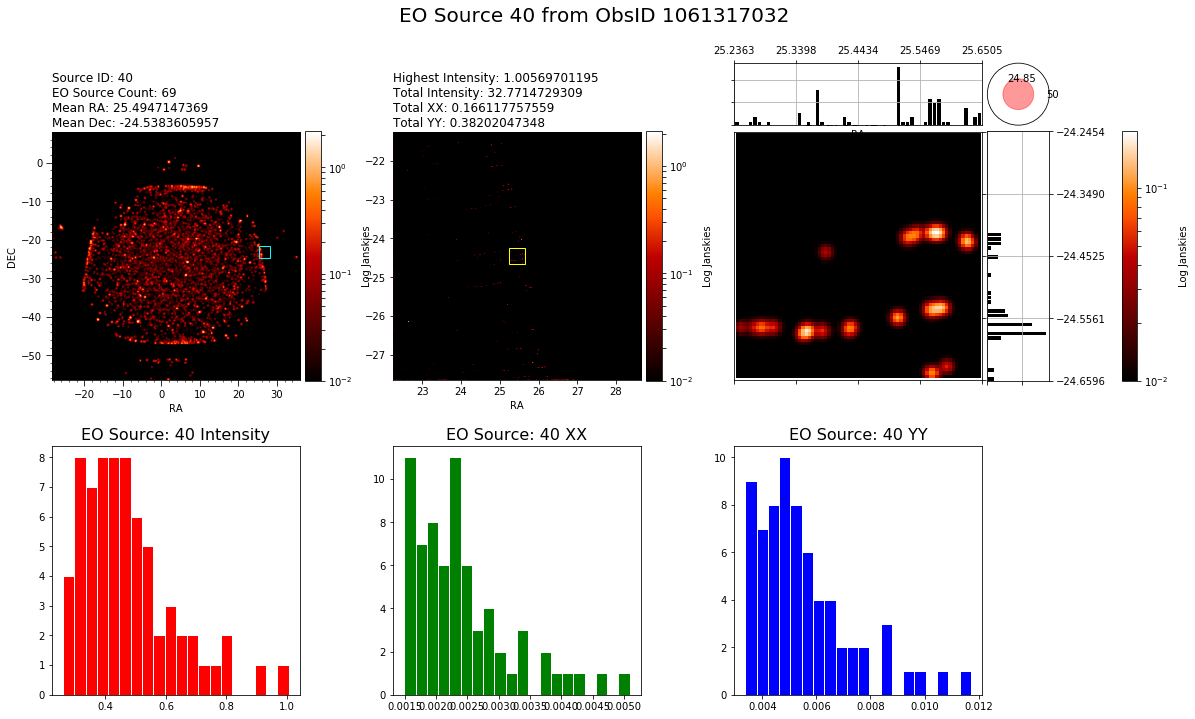

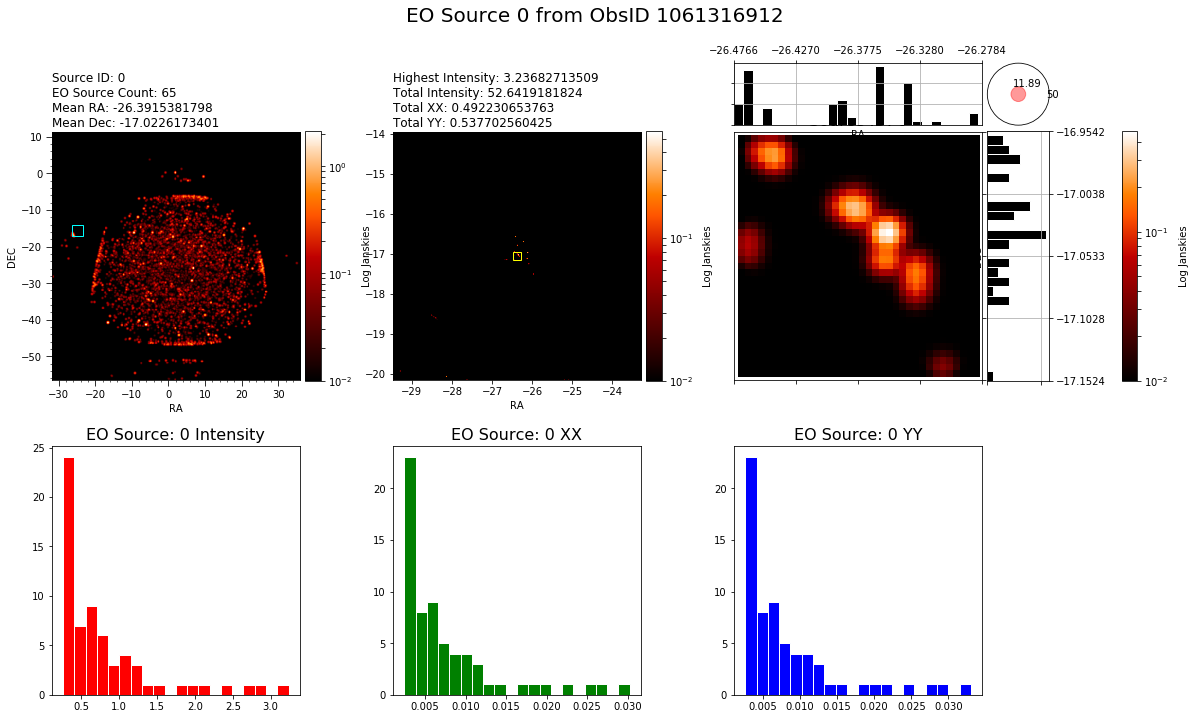

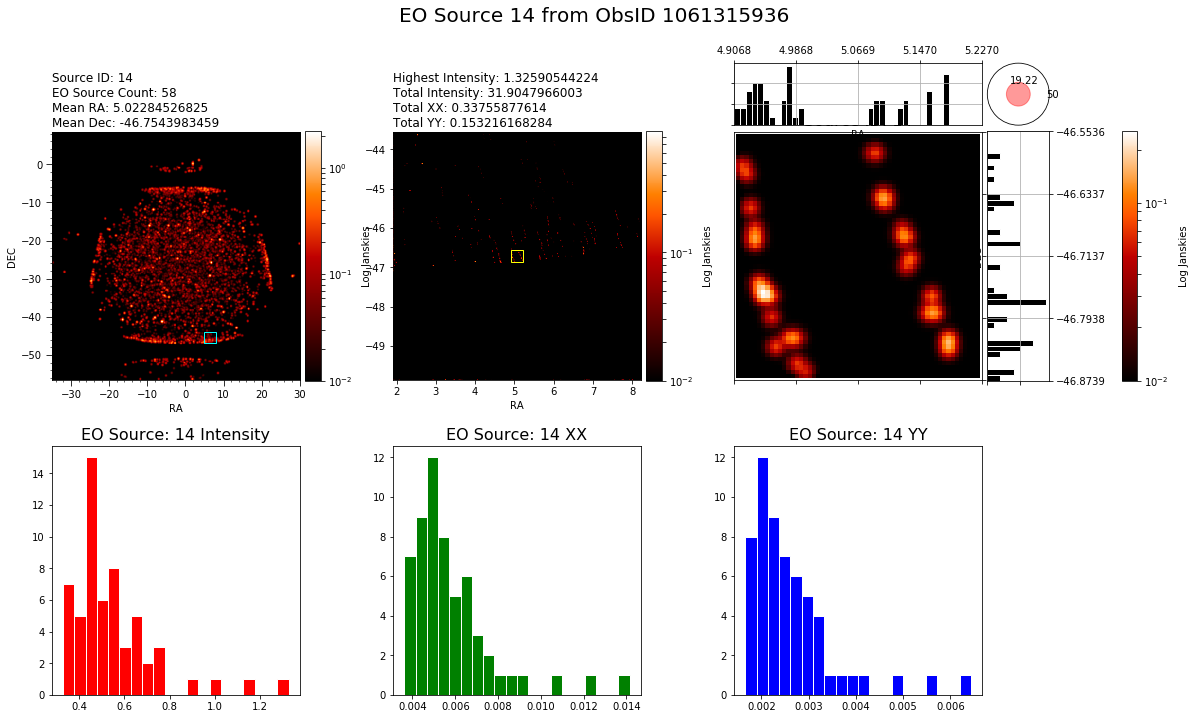

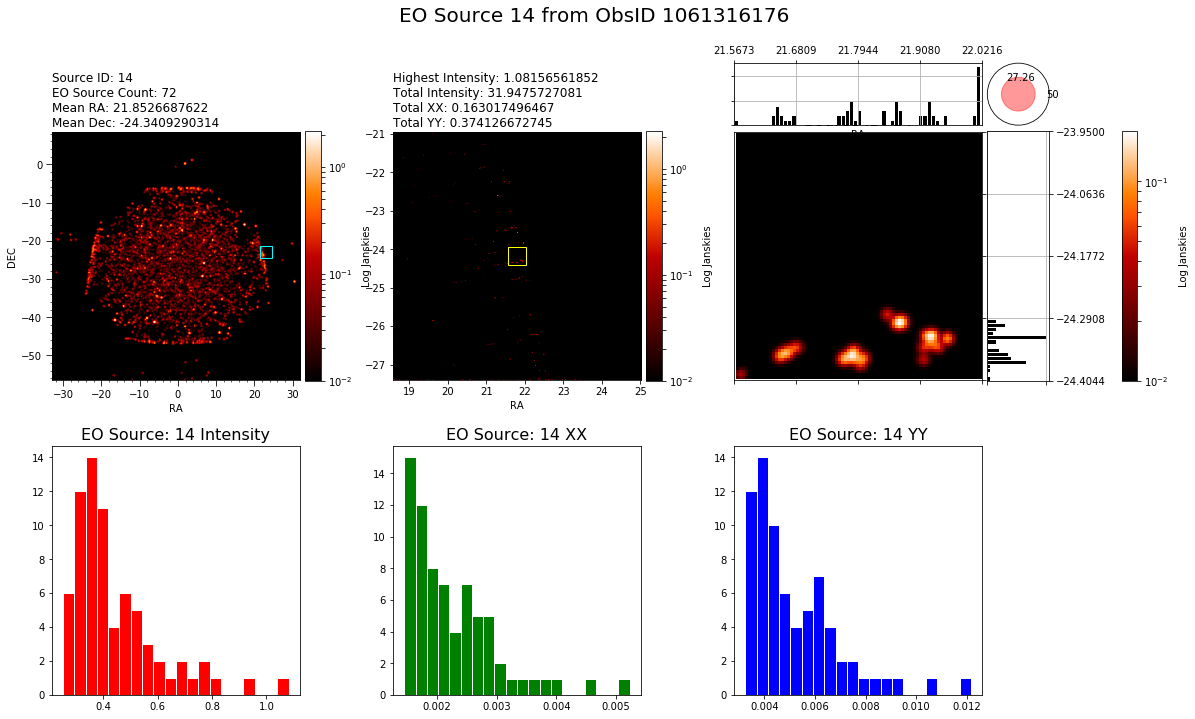

In [48]:
plotEO(thedata,5,30,0.0055)

In [15]:
len(thedata['data'][0]['source_array'])

6092

In [20]:
allIntensities(thedata['data'][0])

element 0 has intensity [ 25.67998886]
element 1 has intensity [ 21.36063766]
element 2 has intensity [ 18.56617737]
element 3 has intensity [ 17.77282524]
element 4 has intensity [ 17.26530457]
element 5 has intensity [ 14.8321476]
element 6 has intensity [ 14.51512051]
element 7 has intensity [ 14.00365257]
element 8 has intensity [ 12.04103279]
element 9 has intensity [ 11.58290768]
element 10 has intensity [ 12.47717667]
element 11 has intensity [ 10.76248074]
element 12 has intensity [ 10.5430994]
element 13 has intensity [ 13.22972775]
element 14 has intensity [ 10.15056896]
element 15 has intensity [ 10.10909176]
element 16 has intensity [ 9.89599991]
element 17 has intensity [ 16.1071434]
element 18 has intensity [ 9.59002686]
element 19 has intensity [ 30.36472893]
element 20 has intensity [ 9.41078091]
element 21 has intensity [ 9.21573067]
element 22 has intensity [ 9.29402161]
element 23 has intensity [ 9.12196255]
element 24 has intensity [ 8.94520473]
element 25 has inten

56
20
27
36
44
32
17
23
20
33
93
81


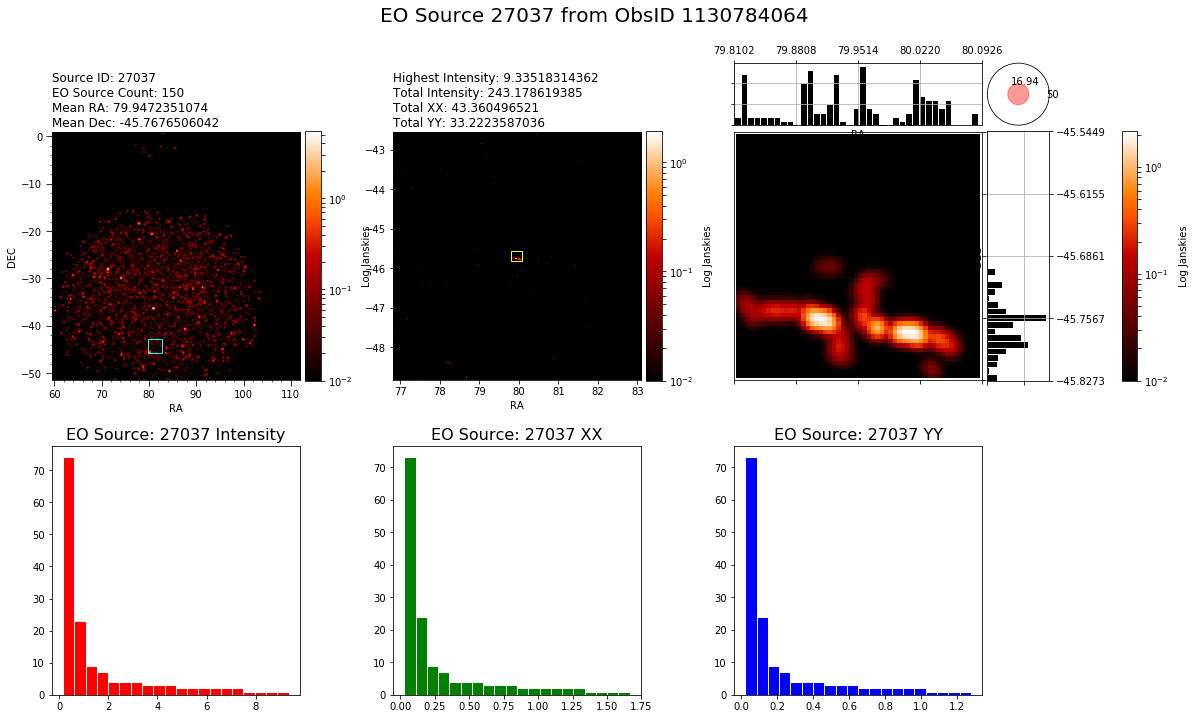

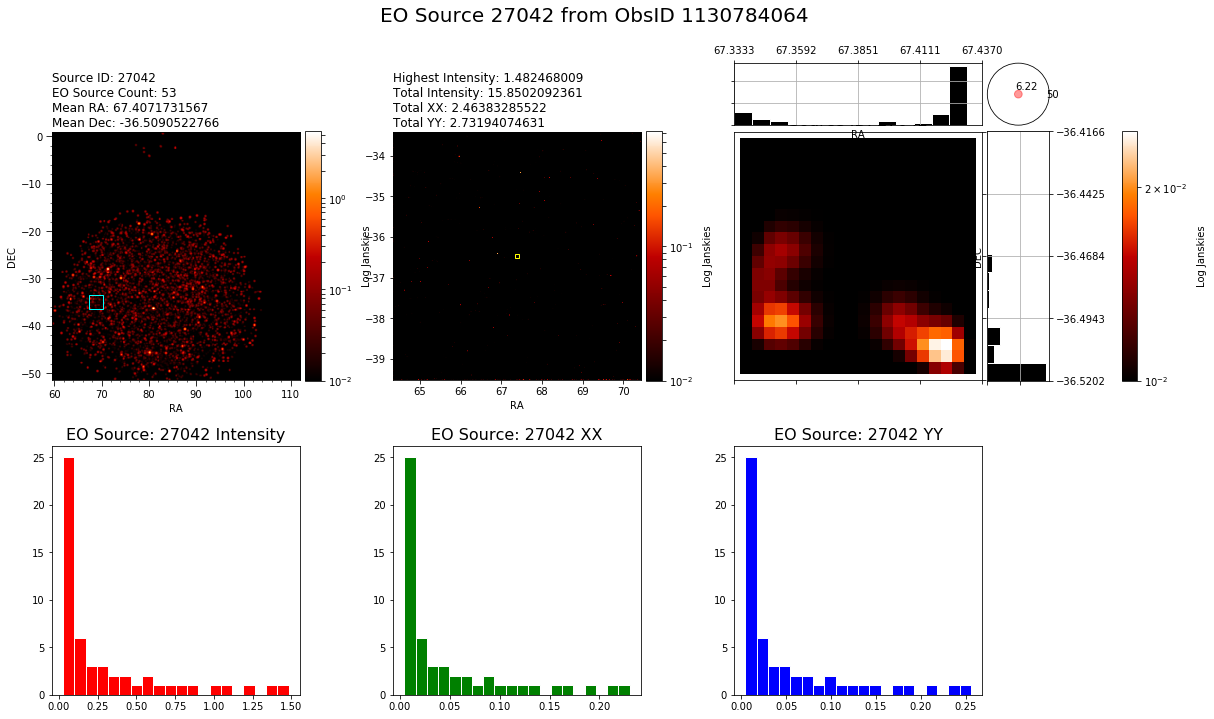

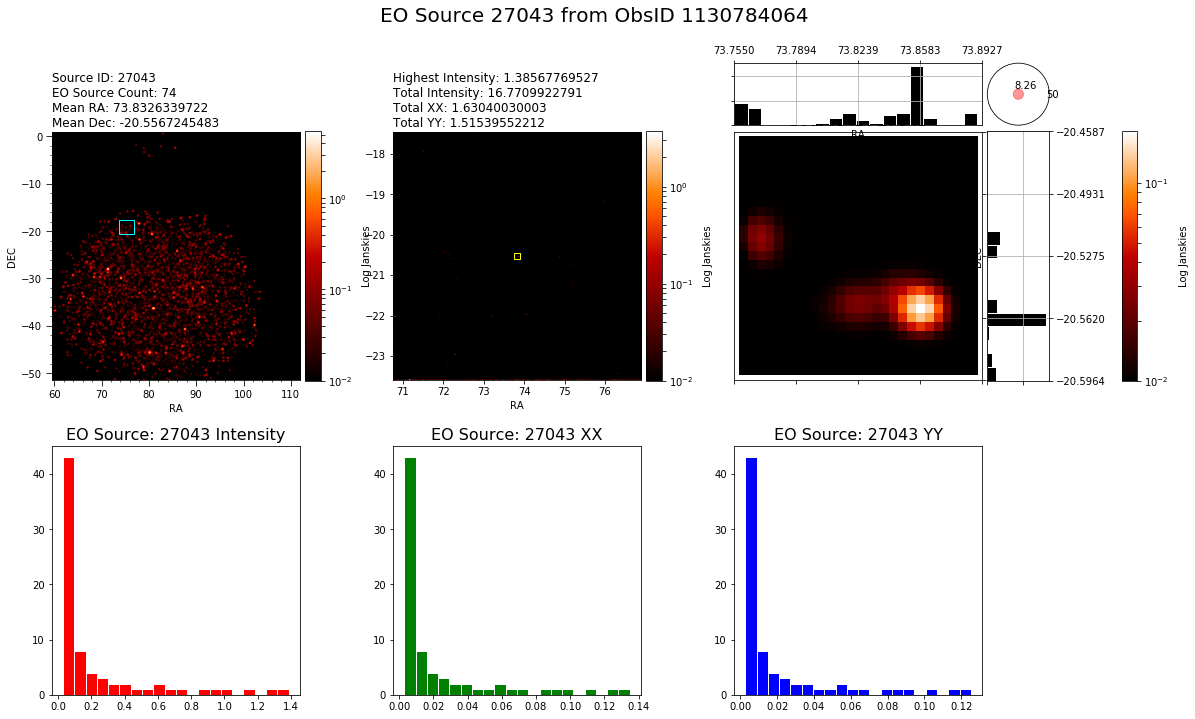

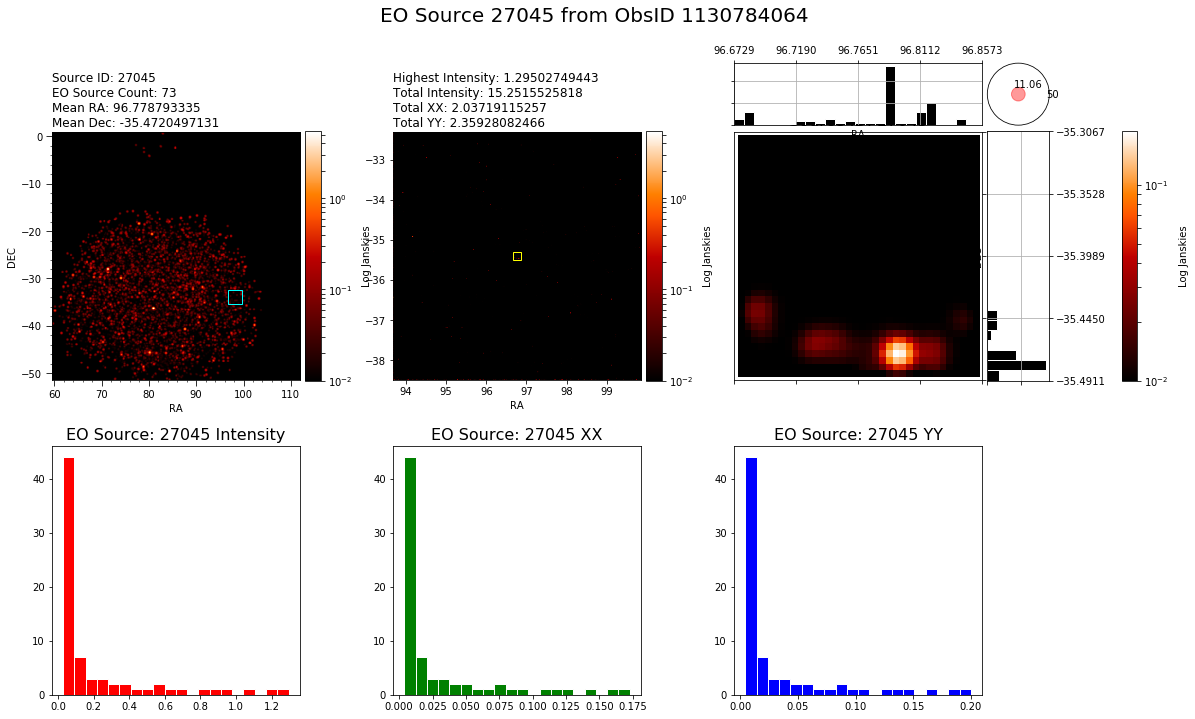

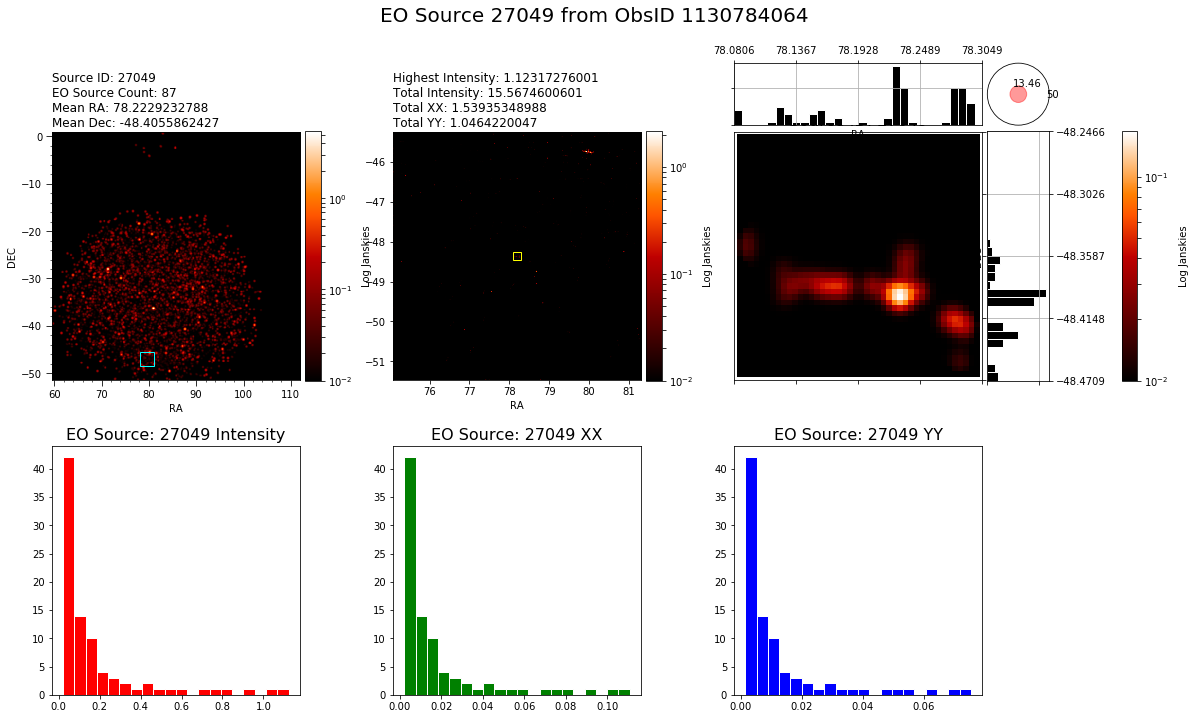

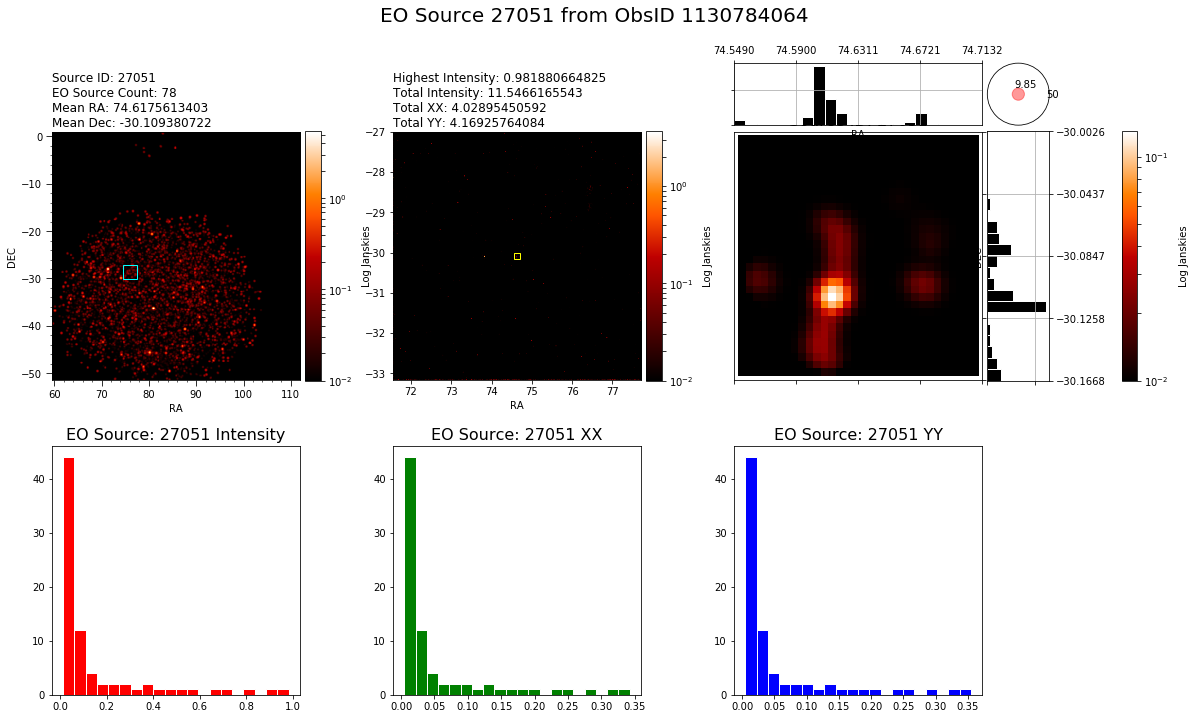

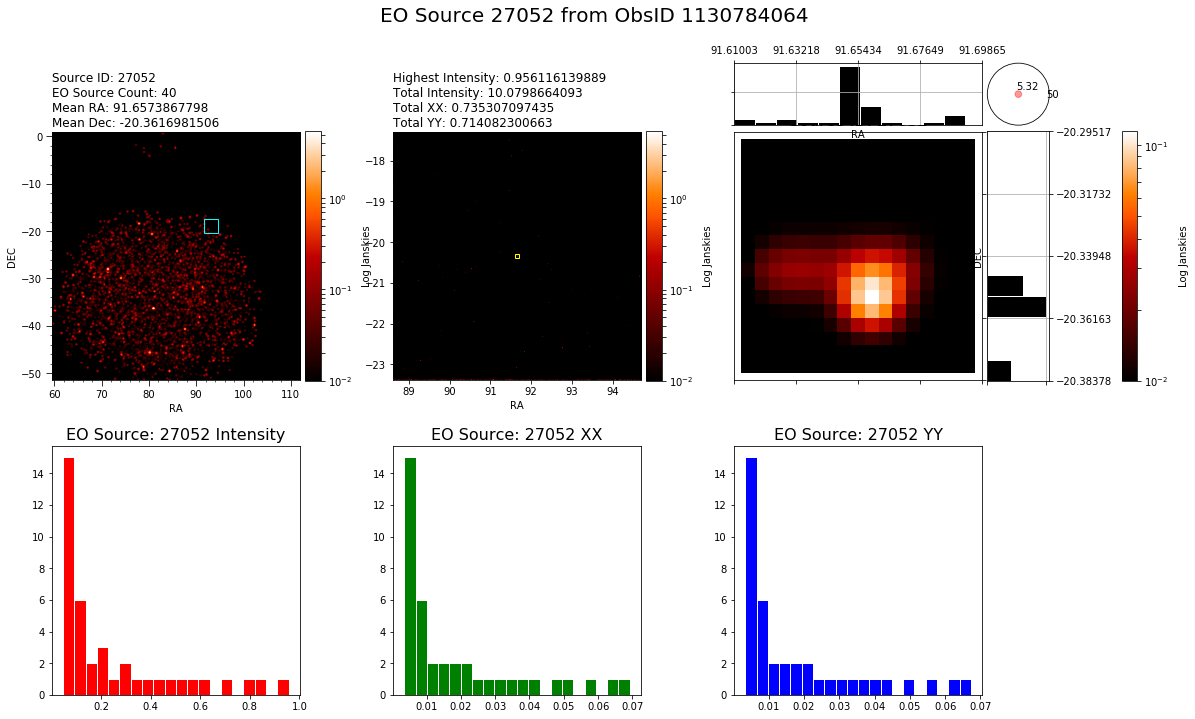

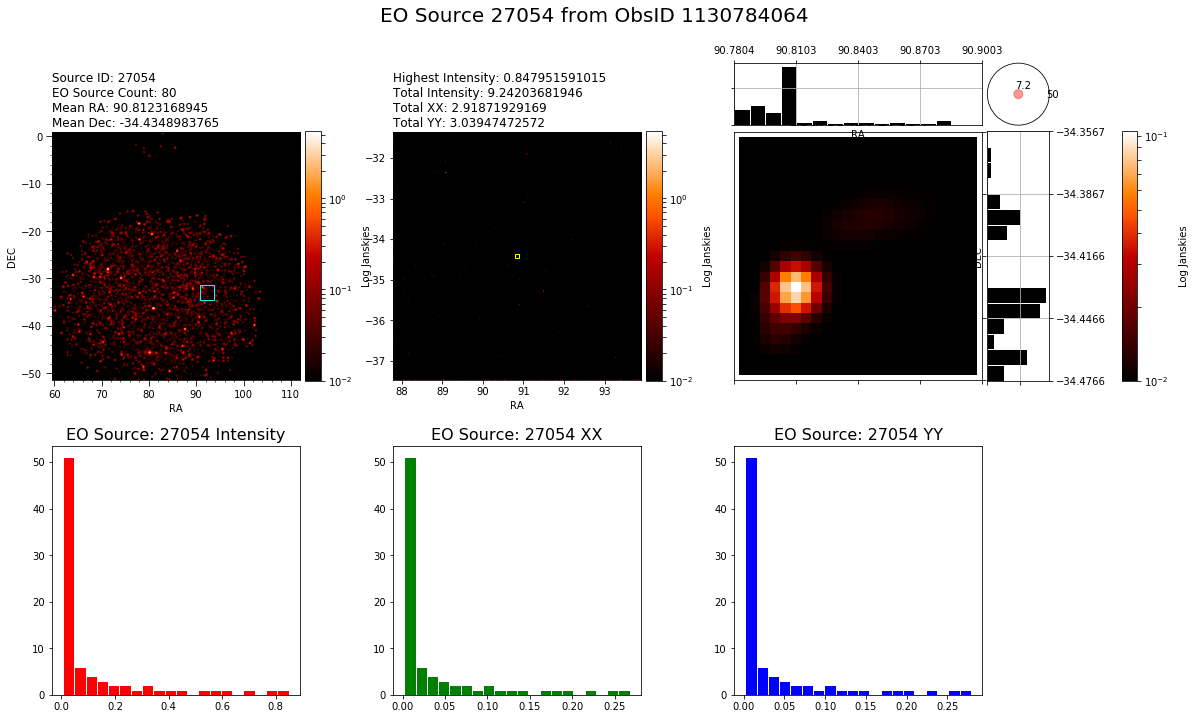

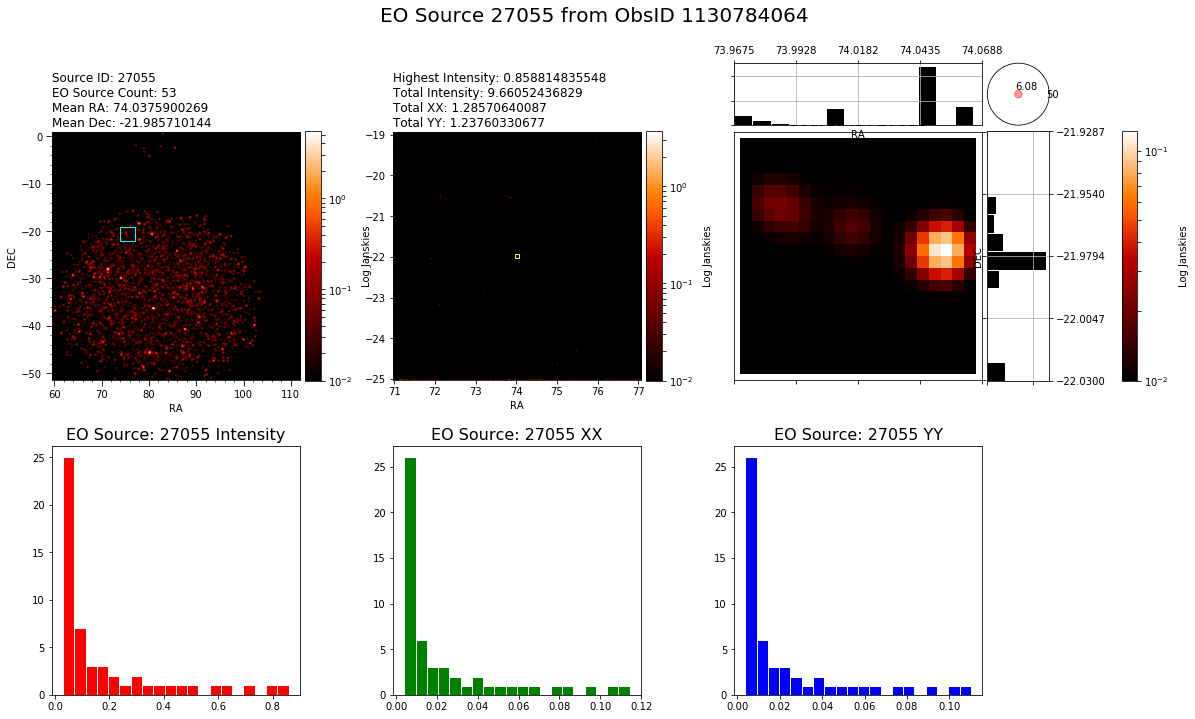

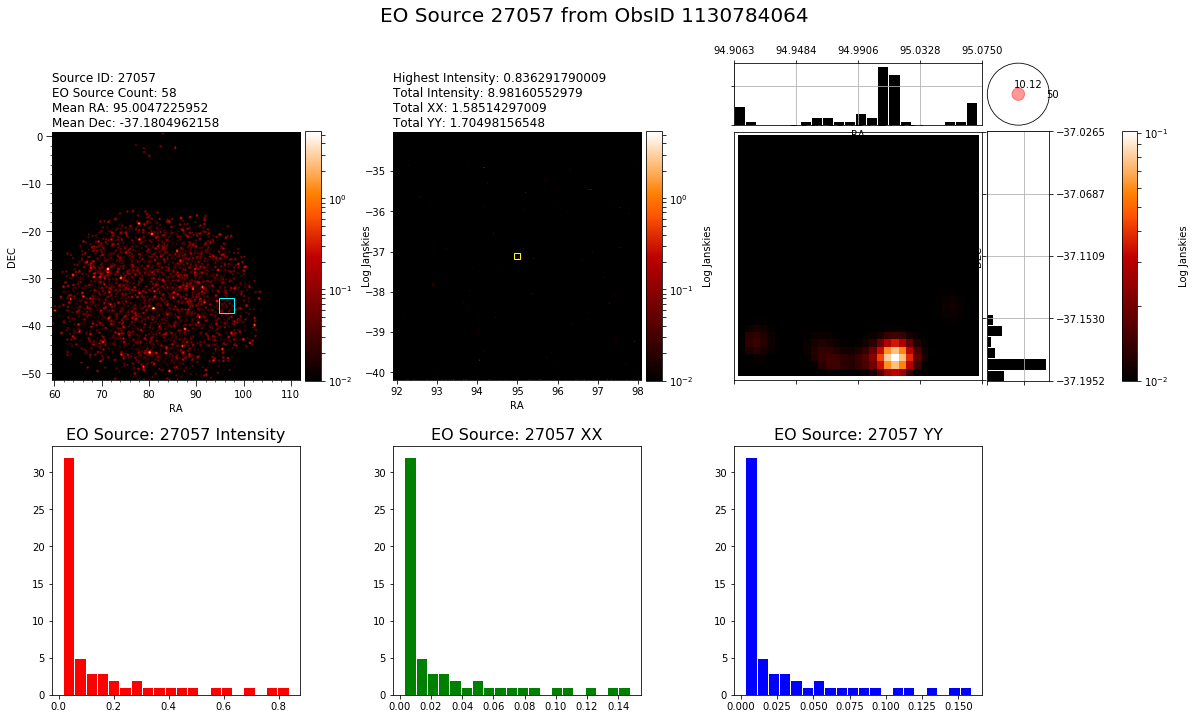

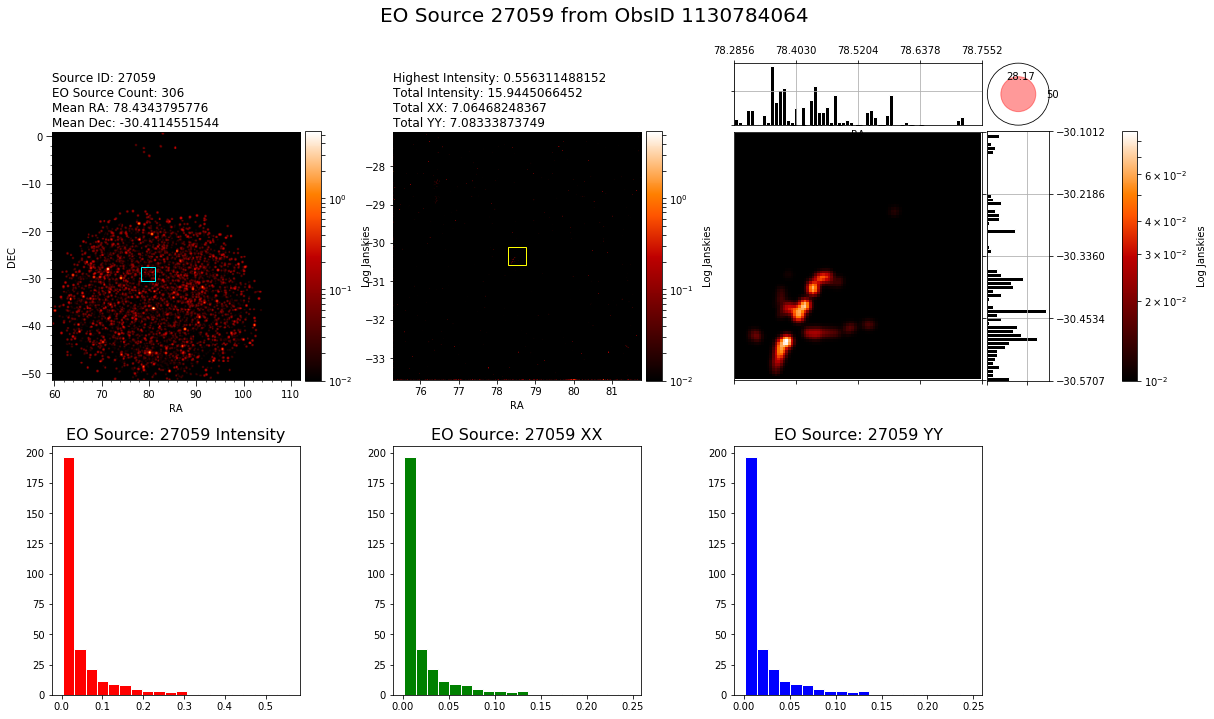

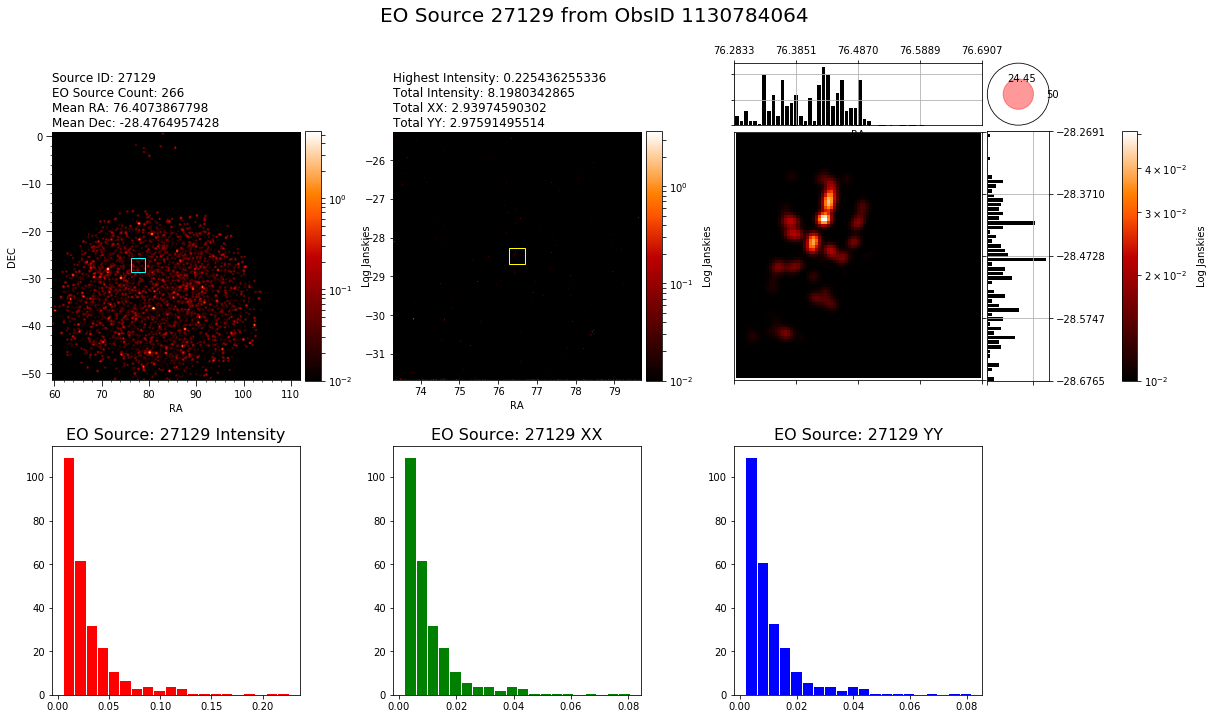

In [63]:
plotEO(dataa1,1,8,0.005)

63
20
37
59
27
17
63
19
15
34
18
49


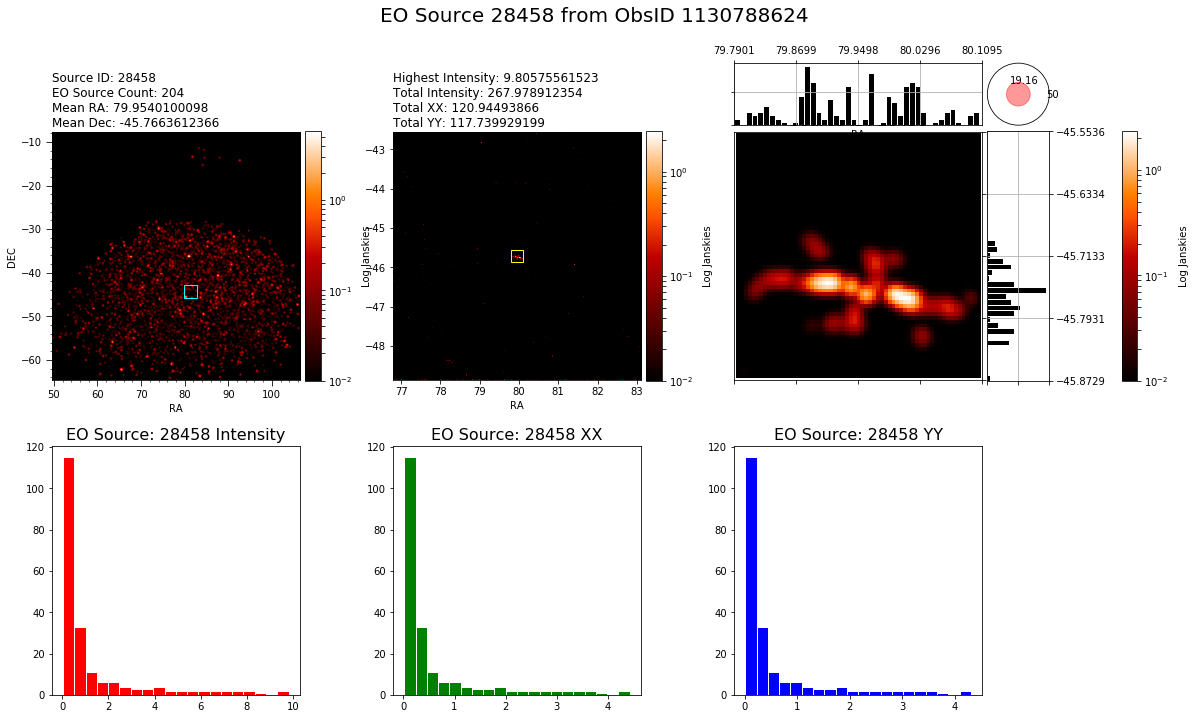

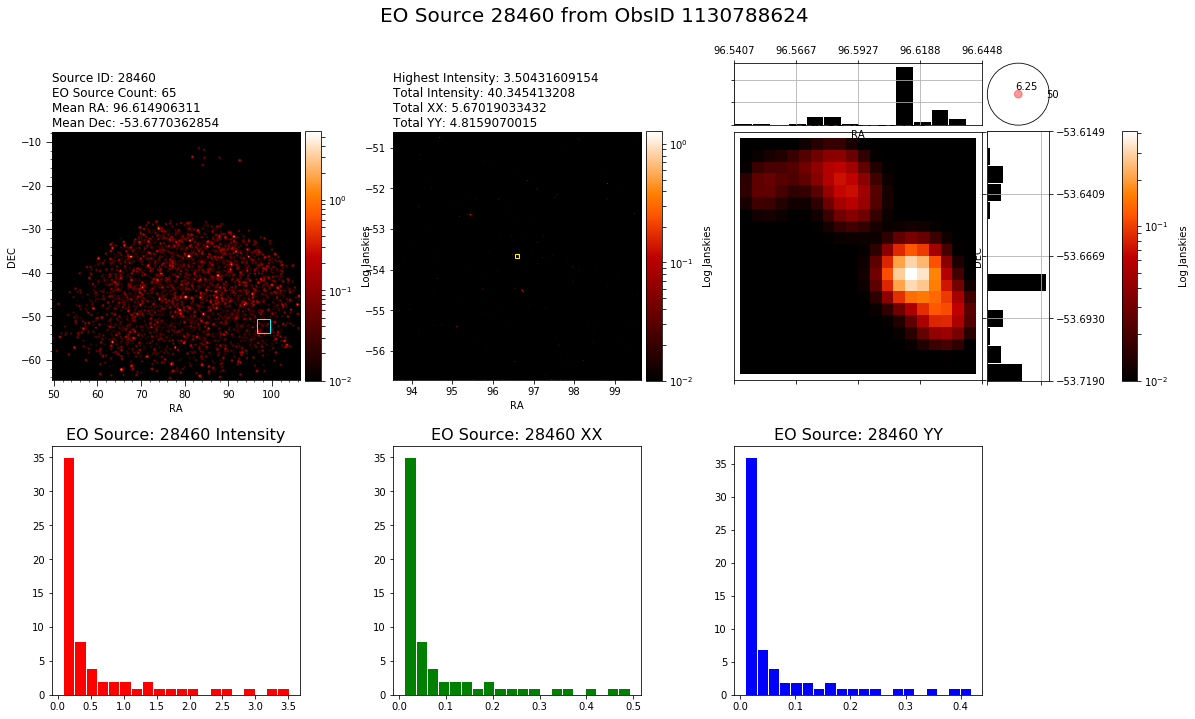

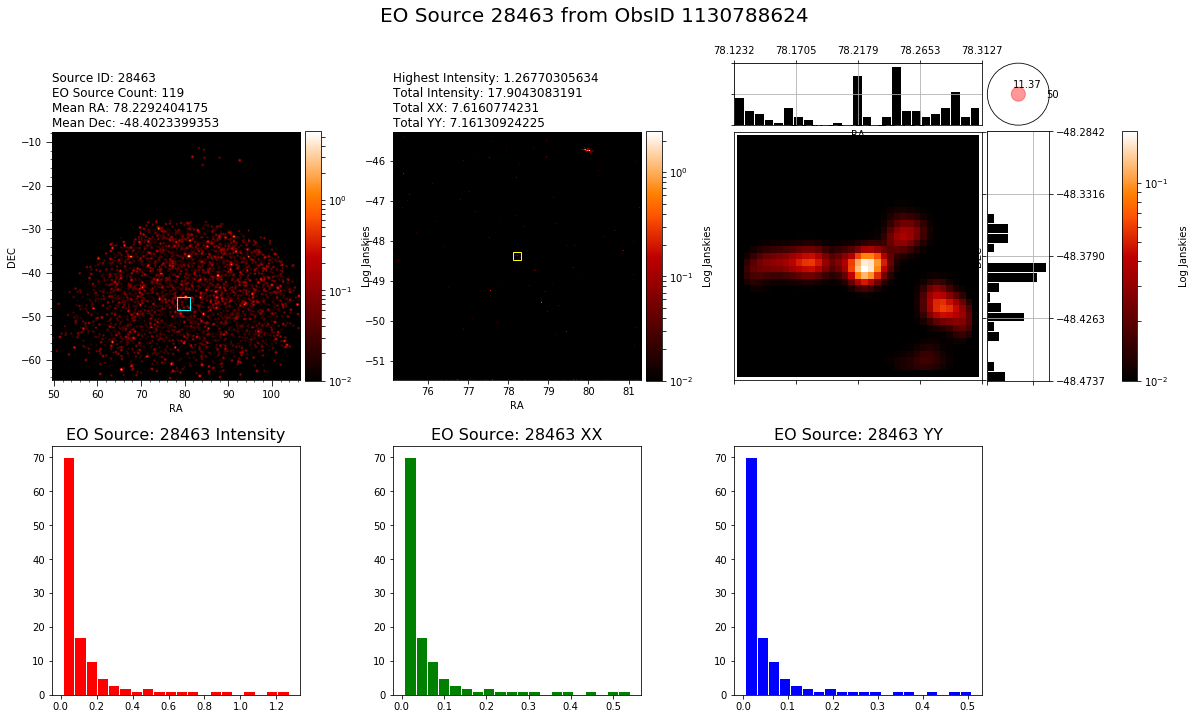

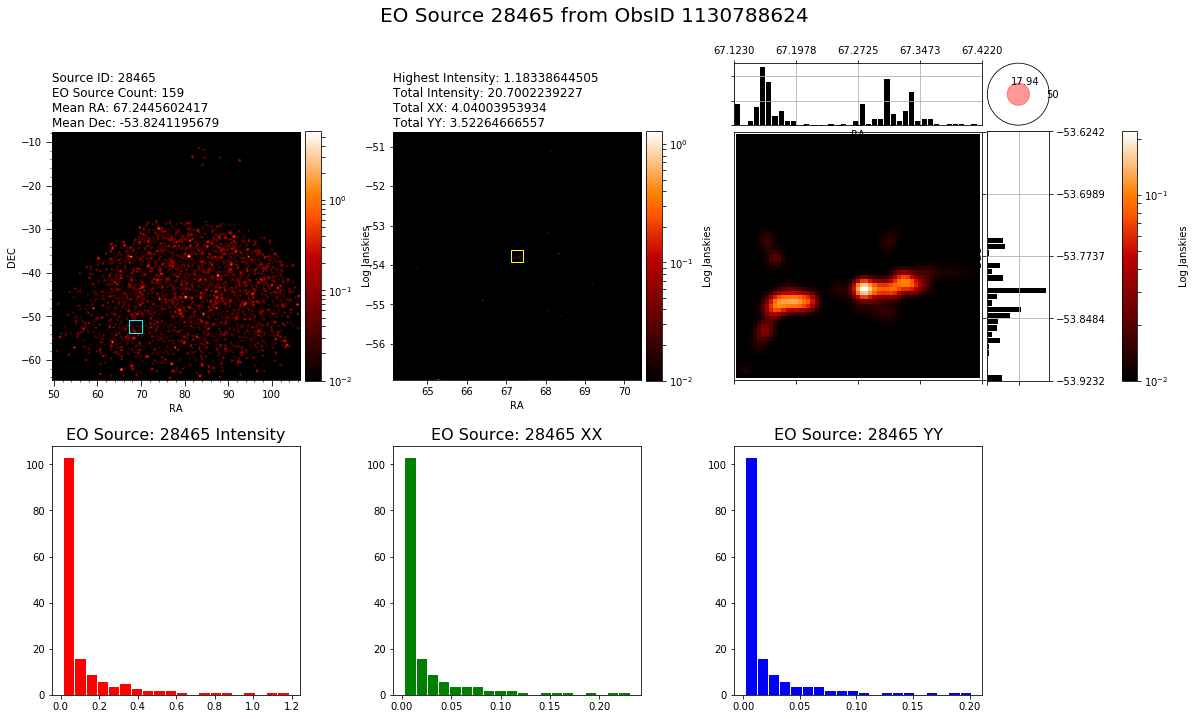

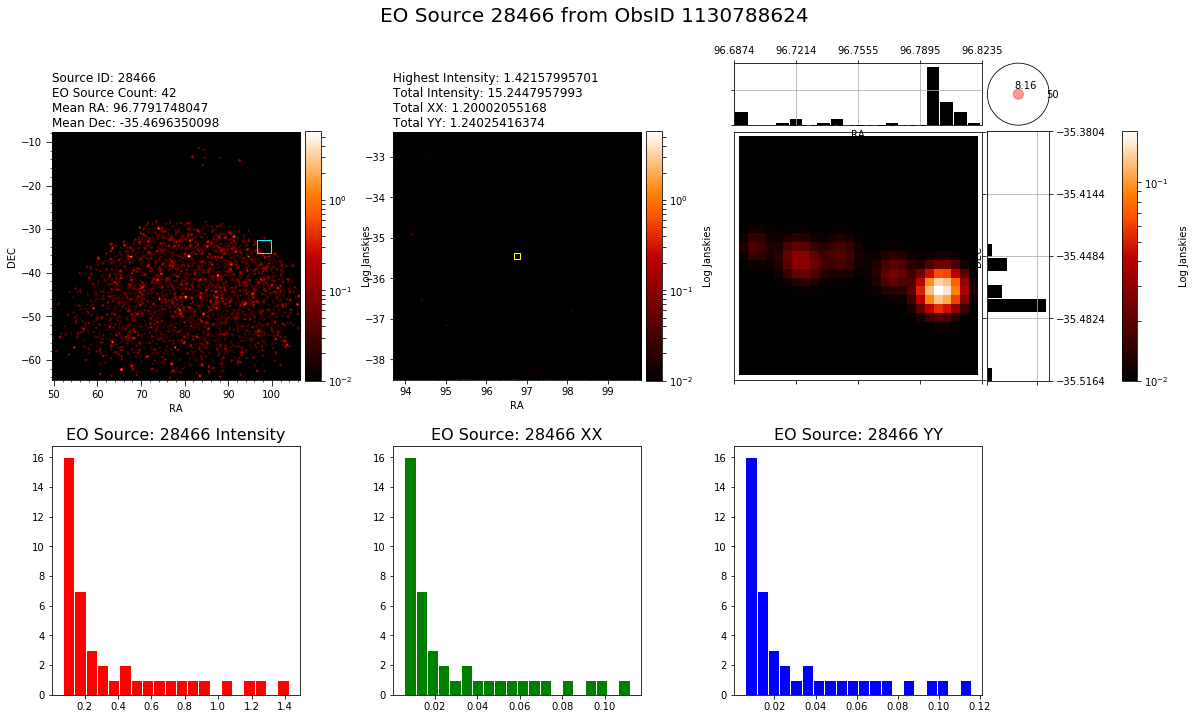

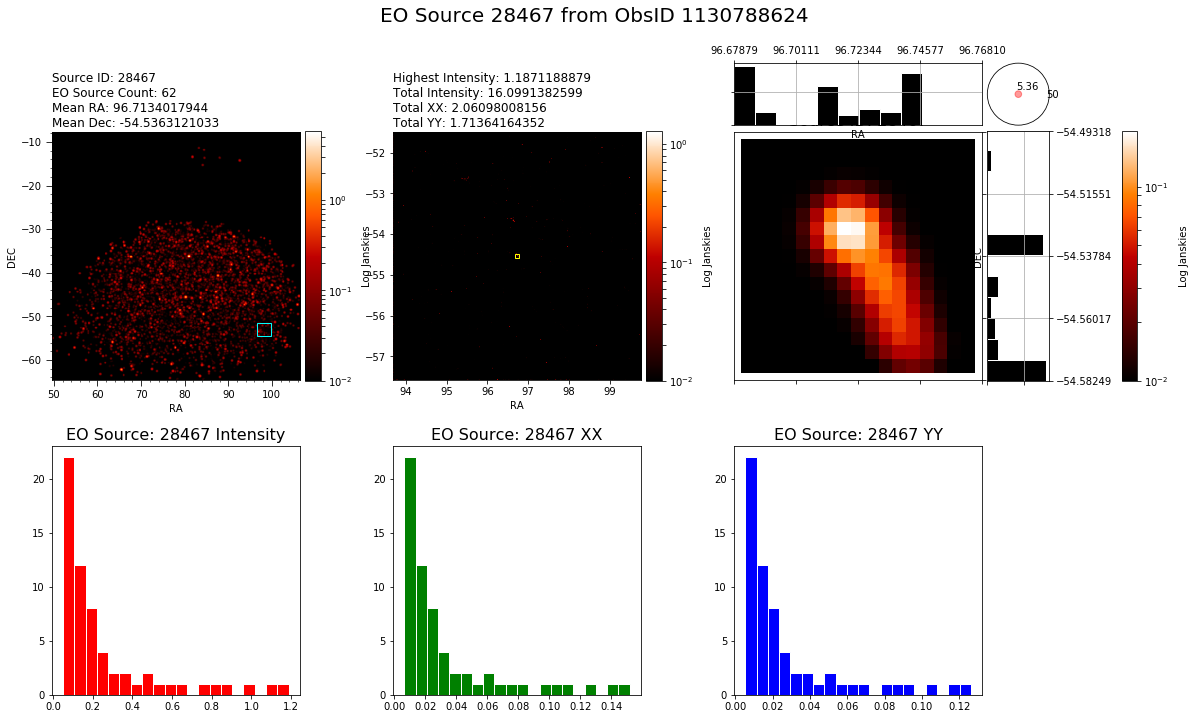

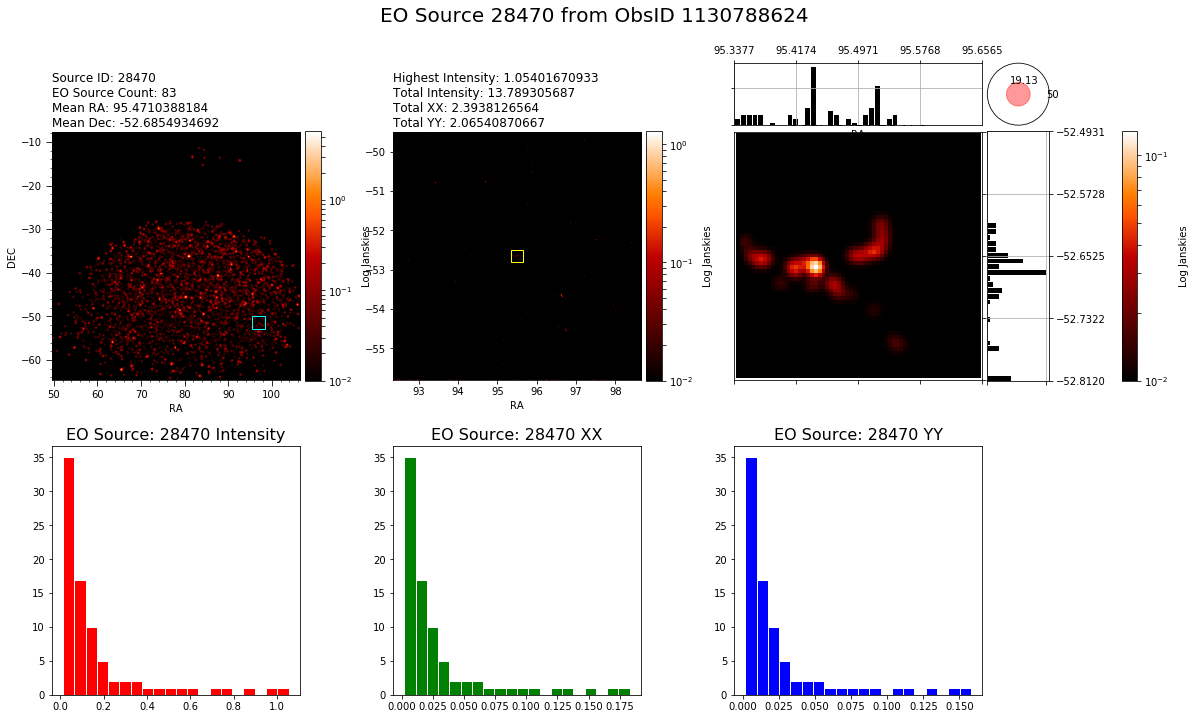

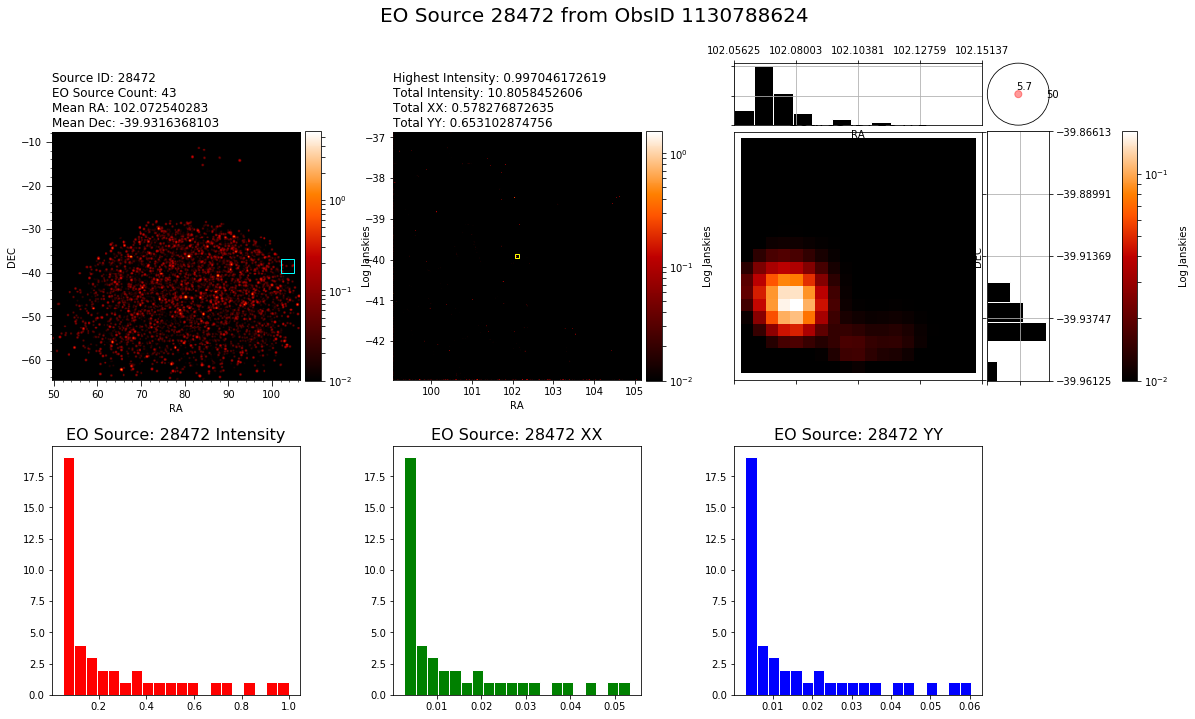

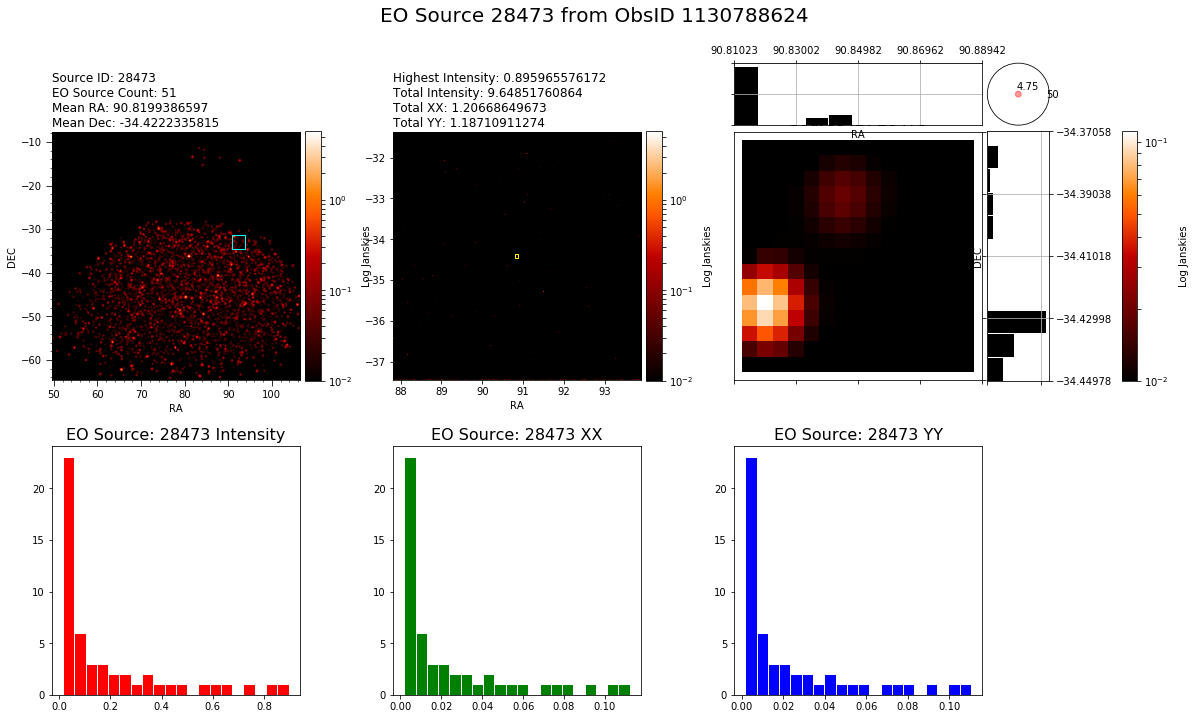

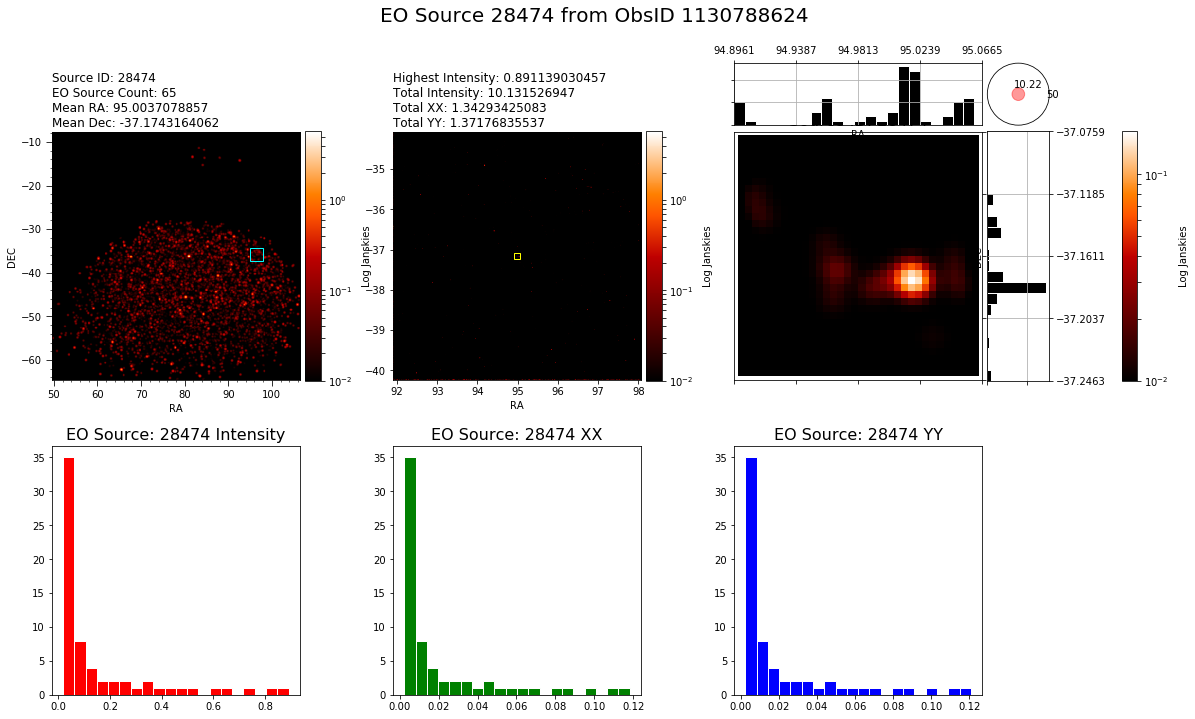

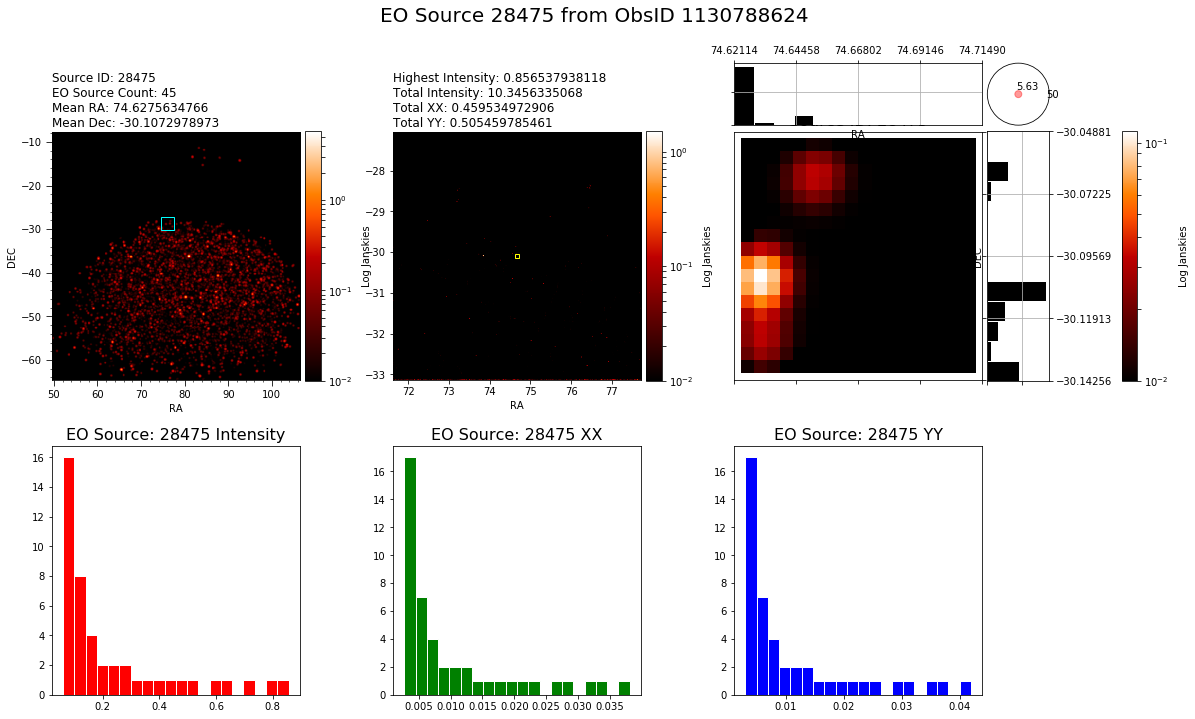

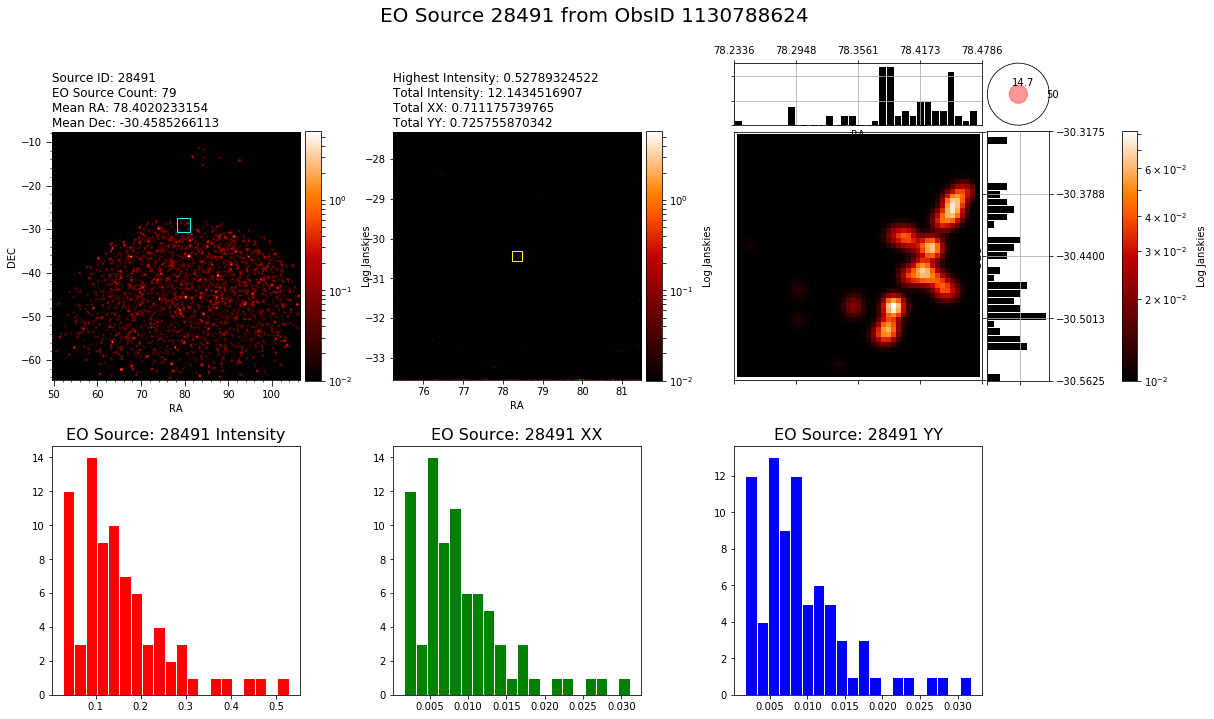

In [64]:
plotEO(dataa2,1,8,0.005)

In [56]:
allIntensities(dataa1['data'][0])

element 0 has intensity [ 243.17863464]
element 1 has intensity [ 53.17067719]
element 2 has intensity [ 35.93229675]
element 3 has intensity [ 16.11812592]
element 4 has intensity [ 15.85020447]
element 5 has intensity [ 16.770998]
element 6 has intensity [ 14.68010616]
element 7 has intensity [ 15.25155354]
element 8 has intensity [ 13.38228893]
element 9 has intensity [ 15.56746101]
element 10 has intensity [ 12.69745159]
element 11 has intensity [ 11.54661369]
element 12 has intensity [ 10.07986736]
element 13 has intensity [ 9.66248226]
element 14 has intensity [ 9.24203873]
element 15 has intensity [ 9.66052437]
element 16 has intensity [ 8.6770134]
element 17 has intensity [ 8.98160458]
element 18 has intensity [ 8.44285965]
element 19 has intensity [ 15.94450951]
element 20 has intensity [ 8.09787941]
element 21 has intensity [ 7.43732023]
element 22 has intensity [ 7.26064587]
element 23 has intensity [ 7.00456476]
element 24 has intensity [ 6.97752237]
element 25 has intensit

In [57]:
allIntensities(dataa2['data'][0])

element 0 has intensity [ 267.97894287]
element 1 has intensity [ 56.40819931]
element 2 has intensity [ 40.34539795]
element 3 has intensity [ 14.70861816]
element 4 has intensity [ 17.9043026]
element 5 has intensity [ 14.5609436]
element 6 has intensity [ 20.70022202]
element 7 has intensity [ 15.24479866]
element 8 has intensity [ 16.09913635]
element 9 has intensity [ 14.03055668]
element 10 has intensity [ 12.51706028]
element 11 has intensity [ 13.78930378]
element 12 has intensity [ 10.63161564]
element 13 has intensity [ 10.80584335]
element 14 has intensity [ 9.64851665]
element 15 has intensity [ 10.13152695]
element 16 has intensity [ 10.34563446]
element 17 has intensity [ 8.74139404]
element 18 has intensity [ 8.46451187]
element 19 has intensity [ 8.14885044]
element 20 has intensity [ 7.37272501]
element 21 has intensity [ 7.28280115]
element 22 has intensity [ 7.20065975]
element 23 has intensity [ 7.16444826]
element 24 has intensity [ 7.06491709]
element 25 has inten